In [280]:
import pandas as pd
from pandas import option_context
import numpy as np
import pickle

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.compose import ColumnTransformer

import xgboost as xgb
from xgboost import XGBClassifier

import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv('04-data/preprocessed_app_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22010 entries, 0 to 22009
Data columns (total 56 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   title                     22010 non-null  object 
 1   description               22010 non-null  object 
 2   summary                   22009 non-null  object 
 3   installs                  22010 non-null  object 
 4   minInstalls               22010 non-null  float64
 5   score                     22010 non-null  float64
 6   ratings                   22010 non-null  float64
 7   reviews                   22010 non-null  float64
 8   histogram                 22010 non-null  object 
 9   price                     22010 non-null  float64
 10  free                      22010 non-null  int64  
 11  currency                  22010 non-null  object 
 12  sale                      22010 non-null  bool   
 13  offersIAP                 22010 non-null  bool   
 14  inAppP

In [3]:
df_sentiment = pd.read_csv('04-data/sentiment_topics_apps.csv')

In [4]:
df= pd.merge(
    df,
    df_sentiment,
    how="inner",
    on='appId',
    left_index=False,
    right_index=False,
    sort=True,
    suffixes=("_x", "_y"),
    copy=True,
    indicator=False,
    validate=None,
)

In [5]:
df = df[df['genre'] != 'Events']

In [281]:
with option_context('display.max_colwidth', 600):
    display(df.sort_values('score').head(60))

,title,description,summary,installs,minInstalls,score,ratings,reviews,histogram,price,free,currency,sale,offersIAP,inAppProductPrice,size,androidVersion,androidVersionText,developer,developerId,privacyPolicy,developerInternalID,genre,genreId,icon,headerImage,screenshots,video,videoImage,contentRating,contentRatingDescription,adSupported,containsAds,released,updated,version,recentChanges,comments,editorsChoice,appId,url,year,updated_year,description_clean,hist_clean,star_1,star_2,star_3,star_4,star_5,top_developer,current_date,days,installs_day,updated_days,has_video,Unnamed: 0,app_ads,compatibility,updates,features,bugs,payments,use_support,compound
7390,Ikariam Mobile,"As ruler of an island kingdom, you build up grand citadels and storm into exciting battles with the armies of your fellow players.\r\n\r\nIn Ikariam you have command over experienced architects, soldiers and ingenious diplomats. Your new culture rises up between the glitteringly blue sea and the fine white sands of a small island. But to attain growth you will need a constant supply of resources and accommodation for your people. Mine your resources or defeat your fellow players on the battlefield for a chance of honour and a chance to get to their resources. On top of that, you can engage...","Construct, fight and research: let your island kingdom bloom!","1,000,000+",1000000.0,1.324779,57642.0,18459.0,"[50837, 1859, 1149, 629, 3168]",0.0,1,USD,False,True,$4.99 - $44.99 per item,43M,2.3,2.3 and up,Gameforge 4D GmbH,Gameforge+4D+GmbH,http://us.gameforge.com/games/privacy/,6.975438e+18,Arcade,GAME_ARCADE,https://play-lh.googleusercontent.com/6riu7jSumy_n1jVEed-_Xq3cn9rLC2NWaVwx2uEVWcLjSvtTEgGAM4i9r9rd-bqB30o,https://play-lh.googleusercontent.com/i6-vKvrXV9lI_wnFHMh7-8HyA0hucW3UuOKNPf71oFDa9XeQmJcO9oqXhnbLOcFwwe4,"['https://play-lh.googleusercontent.com/SgARbCzjo4Xr_9c0IXqTiDfqM3zik_R4pNry8B23pmuLnyJiTJjBgpEzy-1ijqd6Dg', 'https://play-lh.googleusercontent.com/lE8mpPVTWxMTGq3nZ7cMk2It1sAF2BH3RHi2Lenyt8xGfJ-YrL-dMWyDeB50__OL3hl9', 'https://play-lh.googleusercontent.com/2T1xRY1LI1rfHoxXDvIJ-GHWX2h99vpv4U3n6-ClsQdk8hGxiOMHASUdngR-NGsm55yu', 'https://play-lh.googleusercontent.com/zASQKYbTHtp8wfnVAEbPhLilgYFtMrldL7nx46zxo1idimqEdjx9iOv9S7KKE9TbqQ', 'https://play-lh.googleusercontent.com/434qLLSlB1u_Vs69ldA_xlxdZ-Y4U1Nlu3jn3CpVHYdw-oJN4zdxhEn3054d496-8v0']",https://www.youtube.com/embed/64ePhFIKUA4?ps=play&vq=large&rel=0&autohide=1&showinfo=0,https://i.ytimg.com/vi/64ePhFIKUA4/hqdefault.jpg,Everyone,NaN,NaN,0,"Jul 9, 2013",2017-11-29 07:57:15,1.11.0,• Android 8,"[""It Would be nice if they made it compatible with today's technology. Bit disappointing for a game I don't mind spending money in. I guess they'll be losing my business and support after 15yrs of playing ikariam. Very disappointing! I wish they would spend more time on fixing issues rather then opening new servers all the time. FIX YO SHITE!"", 'This game is really lovely. I loved it as a child and I would love it now. But I am not able to play it on computer. There is just no time for it in this world. However this game has awesome potential as mobile game. You can have your empire in you...",0,com.gameforge.mobilizer.ikariam.sencha,https://play.google.com/store/apps/details?id=com.gameforge.mobilizer.ikariam.sencha&hl=en&gl=us,2013,2017,as ruler of an island kingdom you build up grand citadels and storm into exciting battles with the armies of your fellow playersin ikariam you have command over experienced architects soldiers and ingenious diplomats your new culture rises up between the glitteringly blue sea and the fine white sands of a small island but to attain growth you will need a constant supply of resources and accommodation for your people mine your resources or defeat your fellow players on the battlefield for a chance of honour and a chance to get to their resources on top of that you can engage other cultures ...,"[50837, 1859, 1149, 629, 3168]",50837,1859,1149,629,3168,0,2021-03-04,2795,357.7817

In [7]:
X = df[['ratings','free','containsAds','genre','editorsChoice','contentRating','year','top_developer',
        'installs_day','updated_days','has_video','app_ads', 'compatibility', 'updates',
       'features', 'bugs', 'payments', 'use_support']]

y = df['score']

In [8]:
# Split to create temporary tr and test 
X_tr, X_test, y_tr, y_test = train_test_split(X, y,test_size=.20, random_state=16)

In [9]:
X_tr_cont = X_tr[['ratings','free','containsAds','editorsChoice','top_developer',
        'installs_day','updated_days','has_video','year','app_ads', 'compatibility', 'updates',
       'features', 'bugs', 'payments', 'use_support']]

In [10]:
ohe = OneHotEncoder(drop='first', sparse=False)

ohe.fit(X_tr[['genre','contentRating']])

ohe_x_tr = ohe.transform(X_tr[['genre','contentRating']])

columns = ohe.get_feature_names(['genre','contentRating'])

ohe_x_tr_df = pd.DataFrame(ohe_x_tr, columns=columns, index=X_tr.index)

In [11]:
combo_train_df = pd.concat([X_tr_cont, ohe_x_tr_df], axis=1)

In [12]:
# Further split temporary tr to create train and val
X_train, X_val, y_train, y_val = train_test_split(combo_train_df, y_tr,test_size=.20, random_state=10)

In [13]:
X_train['ratings_cubed'] = np.cbrt(X_train['ratings'])
X_val['ratings_cubed'] = np.cbrt(X_val['ratings'])

<ipython-input-13-78d0eea349ad>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['ratings_cubed'] = np.cbrt(X_train['ratings'])
<ipython-input-13-78d0eea349ad>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val['ratings_cubed'] = np.cbrt(X_val['ratings'])


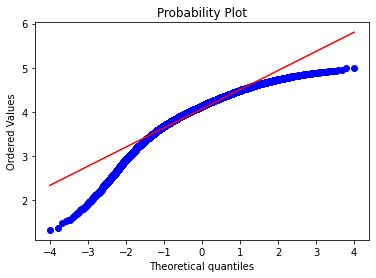

In [14]:
from scipy import stats 
fig = plt.figure() 
prob = stats.probplot(df['score'], plot=plt)

/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


- Total number of ratings: 21987
- Mean of distribution of rating : 4.0676891002683195
- Standard deviation: 0.4488755964730774


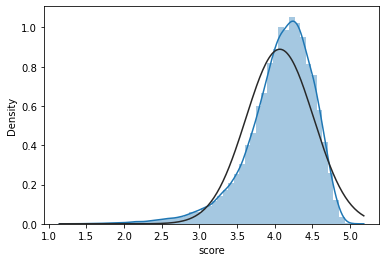

In [15]:
sns.distplot(df['score'],fit=stats.norm)
print('- Total number of ratings:', len(df['score']))
print('- Mean of distribution of rating :', np.mean(df['score']))
print('- Standard deviation:', np.std(df['score']))

<ipython-input-16-19017ad47020>:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  pd.plotting.scatter_matrix(df[['ratings','installs_day','updated_days','app_ads', 'compatibility', 'updates',


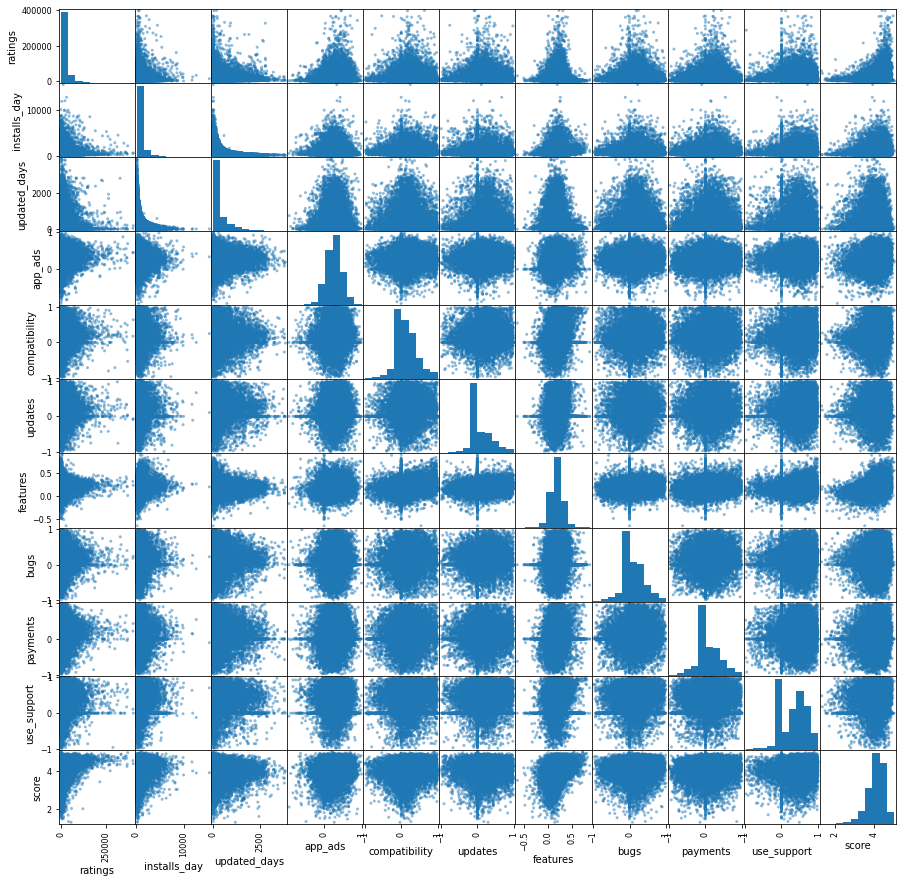

In [16]:
fig, ax = plt.subplots(figsize=(15, 15))
pd.plotting.scatter_matrix(df[['ratings','installs_day','updated_days','app_ads', 'compatibility', 'updates',
       'features', 'bugs', 'payments', 'use_support','score']], ax=ax);

In [17]:
X_train.columns

Index(['ratings', 'free', 'containsAds', 'editorsChoice', 'top_developer',
       'installs_day', 'updated_days', 'has_video', 'year', 'app_ads',
       'compatibility', 'updates', 'features', 'bugs', 'payments',
       'use_support', 'genre_Adventure', 'genre_Arcade', 'genre_Art & Design',
       'genre_Auto & Vehicles', 'genre_Beauty', 'genre_Board',
       'genre_Books & Reference', 'genre_Business', 'genre_Card',
       'genre_Casino', 'genre_Casual', 'genre_Comics', 'genre_Communication',
       'genre_Dating', 'genre_Education', 'genre_Entertainment',
       'genre_Finance', 'genre_Food & Drink', 'genre_Health & Fitness',
       'genre_House & Home', 'genre_Libraries & Demo', 'genre_Lifestyle',
       'genre_Maps & Navigation', 'genre_Medical', 'genre_Music & Audio',
       'genre_News & Magazines', 'genre_Parenting', 'genre_Personalization',
       'genre_Photography', 'genre_Productivity', 'genre_Puzzle',
       'genre_Racing', 'genre_Role Playing', 'genre_Shopping',
       'ge

## Regression

In [18]:
features = ['ratings_cubed']

In [19]:
lr = LinearRegression()

lr.fit(X_train[features], y_train)

y_pred = lr.predict(X_train[features])
print('R^2 of linear regression on train set: {:.2f}'.format(lr.score(X_train[features], y_train)))
print('MSE of linear regression on train set: {:.2f}'.format((mean_squared_error(y_train, y_pred))))
print('MAE of linear regression on train set: {:.2f}'.format((mean_absolute_error(y_train, y_pred))))

R^2 of linear regression on train set: 0.12
MSE of linear regression on train set: 0.18
MAE of linear regression on train set: 0.31


In [20]:
y_predv = lr.predict(X_val[features])
print('R^2 of linear regression on val set: {:.2f}'.format(lr.score(X_val[features], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_val, y_predv))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_predv))))

R^2 of linear regression on val set: 0.11
MSE of linear regression on val set: 0.17
MAE of linear regression on val set: 0.30


In [21]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features].columns, lr.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

ratings_cubed : 0.02


In [22]:
check = X_val.copy()
check['score'] = y_val
check['pred'] = lr.predict(X_val[features])
check['resid'] = check['pred'] - check['score']

In [23]:
high_resid = check.sort_values('resid',ascending =False).head(600)

In [24]:
check.sort_values('resid',ascending =False)

,ratings,free,containsAds,editorsChoice,top_developer,installs_day,updated_days,has_video,year,app_ads,compatibility,updates,features,bugs,payments,use_support,genre_Adventure,genre_Arcade,genre_Art & Design,genre_Auto & Vehicles,genre_Beauty,genre_Board,genre_Books & Reference,genre_Business,genre_Card,genre_Casino,genre_Casual,genre_Comics,genre_Communication,genre_Dating,genre_Education,genre_Entertainment,genre_Finance,genre_Food & Drink,genre_Health & Fitness,genre_House & Home,genre_Libraries & Demo,genre_Lifestyle,genre_Maps & Navigation,genre_Medical,genre_Music & Audio,genre_News & Magazines,genre_Parenting,genre_Personalization,genre_Photography,genre_Productivity,genre_Puzzle,genre_Racing,genre_Role Playing,genre_Shopping,genre_Simulation,genre_Social,genre_Sports,genre_Strategy,genre_Tools,genre_Travel & Local,genre_Trivia,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,ratings_cubed,score,pred,resid
7390,57642.0,1,0,0,0,357.781753,1190,1,2013,0.26572,-0.032281,0.293238,0.136754,0.07910,-0.148733,0.485250,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.628960,1.324779,4.313323,2.988544
3260,6117.0,1,1,0,0,1430.615165,194,0,2019,-0.20830,0.000000,0.000000,-0.018720,0.00000,-0.149200,0.079050,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.288559,1.696825,3.958509,2.261684
8013,17878.0,1,1,0,0,259.538022,21,0,2010,-0.13985,0.159100,0.000000,-0.083657,0.21265,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,26.148070,1.929050,4.095609,2.166559
17098,3380.0,1,1,0,0,717.360115,1234,0,2017,0.14857,0.064636,0.129360,0.210863,0.27356,0.517600,0.474125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,15.007404,1.958580,3.901274,1.942694
1538,9227.0,1,1,0,0,416.840350,772,0,2014,-0.08168,0.043950,0.318200,-0.005590,0.36120,-0.476700,0.410000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,20.974269,2.075757,4.005358,1.929601
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6965,8987.0,1,1,0,1,4444.444444,70,0,2020,0.08942,0.287280,0.000000,0.408043,0.00000,0.000000,0.853700,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.790818,4.901379,4.002158,-0.899220
6651,1205.0,1,1,0,0,2512.562814,15,0,2020,0.00000,0.951867,0.000000,0.829083,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,10.641324,4.727272,3.825113,-0.902160
8064,4457.0,1,1,0,1,2816.901408,145,1,2020,0.62245,0.000000,0.000000,0.603992,0.00000,0.955100,0.943200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,16.456882,4.864333,3.926558,-0.937775
4354,3684.0,1,1,0,1,2123.142251,82,1,2019,0.00000,0.559600,0.000000,0.762732,0.00

In [25]:
low_resid = check[(check['resid'] >= -0.1) & (check['resid'] <= 0.1)]

/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


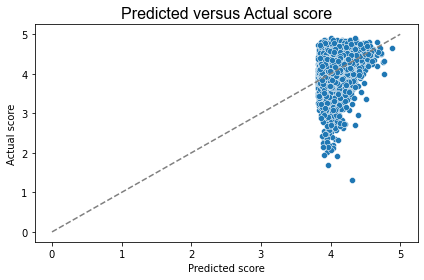

In [26]:
fig, ax = plt.subplots()
sns.scatterplot(y_predv, y_val)
plt.xlabel('Predicted score')
plt.ylabel('Actual score')
ax.plot(np.linspace(0,5,5), np.linspace(0,5,5), ls="--", c="0.5")
plt.tight_layout()
plt.title('Predicted versus Actual score',family='arial',fontsize=16);
plt.tight_layout()
plt.show;

This model is overpredicting values

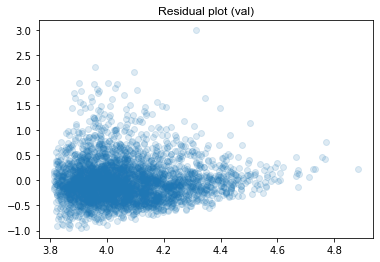

In [27]:
plt.scatter(check['pred'],check['resid'],alpha = 0.15)
plt.title('Residual plot (val)',family='arial',fontsize=12);

## Add features

In [28]:
features2 = ['ratings_cubed','features']

In [29]:
lr2 = LinearRegression()

lr2.fit(X_train[features2], y_train)

y_pred2 = lr2.predict(X_train[features2])
print('R^2 of linear regression on train set: {:.2f}'.format(lr2.score(X_train[features2], y_train)))
print('MSE of linear regression on train set: {:.2f}'.format((mean_squared_error(y_train, y_pred2))))
print('MAE of linear regression on train set: {:.2f}'.format((mean_absolute_error(y_train, y_pred2))))

R^2 of linear regression on train set: 0.23
MSE of linear regression on train set: 0.16
MAE of linear regression on train set: 0.29


In [30]:
y_predv2 = lr2.predict(X_val[features2])
print('R^2 of linear regression on val set: {:.2f}'.format(lr2.score(X_val[features2], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_val, y_predv2))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_predv2))))

R^2 of linear regression on val set: 0.22
MSE of linear regression on val set: 0.14
MAE of linear regression on val set: 0.29


In [31]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features2].columns, lr2.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

ratings_cubed : 0.02
features : 1.18


In [32]:
check2 = X_val.copy()
check2['score'] = y_val
check2['pred'] = lr2.predict(X_val[features2])
check2['resid'] = check2['pred'] - check2['score']

In [33]:
check2.sort_values('resid',ascending = False)

,ratings,free,containsAds,editorsChoice,top_developer,installs_day,updated_days,has_video,year,app_ads,compatibility,updates,features,bugs,payments,use_support,genre_Adventure,genre_Arcade,genre_Art & Design,genre_Auto & Vehicles,genre_Beauty,genre_Board,genre_Books & Reference,genre_Business,genre_Card,genre_Casino,genre_Casual,genre_Comics,genre_Communication,genre_Dating,genre_Education,genre_Entertainment,genre_Finance,genre_Food & Drink,genre_Health & Fitness,genre_House & Home,genre_Libraries & Demo,genre_Lifestyle,genre_Maps & Navigation,genre_Medical,genre_Music & Audio,genre_News & Magazines,genre_Parenting,genre_Personalization,genre_Photography,genre_Productivity,genre_Puzzle,genre_Racing,genre_Role Playing,genre_Shopping,genre_Simulation,genre_Social,genre_Sports,genre_Strategy,genre_Tools,genre_Travel & Local,genre_Trivia,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,ratings_cubed,score,pred,resid
7390,57642.0,1,0,0,0,357.781753,1190,1,2013,0.265720,-0.032281,0.293238,0.136754,0.079100,-0.148733,0.485250,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.628960,1.324779,4.255775,2.930996
3260,6117.0,1,1,0,0,1430.615165,194,0,2019,-0.208300,0.000000,0.000000,-0.018720,0.000000,-0.149200,0.079050,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.288559,1.696825,3.728562,2.031737
17098,3380.0,1,1,0,0,717.360115,1234,0,2017,0.148570,0.064636,0.129360,0.210863,0.273560,0.517600,0.474125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,15.007404,1.958580,3.943016,1.984436
8013,17878.0,1,1,0,0,259.538022,21,0,2010,-0.139850,0.159100,0.000000,-0.083657,0.212650,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,26.148070,1.929050,3.785254,1.856204
16337,11749.0,1,0,0,0,411.353353,64,0,2014,0.492700,0.156457,0.043175,0.123344,0.188986,0.000000,0.568860,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.733535,2.123090,3.970893,1.847803
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12198,13049.0,1,1,0,1,734.214391,555,0,2017,0.467267,0.165167,0.000000,0.013595,0.141400,-0.125200,0.640950,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.542852,4.773455,3.855522,-0.917933
20655,6253.0,1,1,0,1,456.829603,1473,0,2015,-0.094000,-0.874800,0.000000,0.045450,0.000000,0.000000,0.285900,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.423104,4.726400,3.806308,-0.920092
20794,4209.0,1,1,0,0,678.426052,967,0,2017,0.556150,0.000000,0.000000,-0.427400,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,16.145803,4.156398,3.211651,-0.944748
11889,9290.0,1,1,0,0,508.646999,676,0,2015,0.201850,0.06110

/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


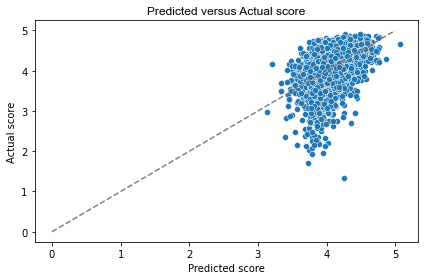

In [34]:
fig, ax = plt.subplots()
sns.scatterplot(y_predv2, y_val)
plt.xlabel('Predicted score')
plt.ylabel('Actual score')
ax.plot(np.linspace(0,5,5), np.linspace(0,5,5), ls="--", c="0.5")
plt.tight_layout()
plt.title('Predicted versus Actual score',family='arial',fontsize=12);
plt.tight_layout()
plt.show;

## App ads

In [35]:
features3 = ['ratings_cubed','features','app_ads']

In [36]:
lr3 = LinearRegression()

lr3.fit(X_train[features3], y_train)

y_pred3 = lr3.predict(X_train[features3])
print('R^2 of linear regression on train set: {:.2f}'.format(lr3.score(X_train[features3], y_train)))
print('MSE of linear regression on train set: {:.2f}'.format((mean_squared_error(y_train, y_pred3))))
print('MAE of linear regression on train set: {:.2f}'.format((mean_absolute_error(y_train, y_pred3))))

R^2 of linear regression on train set: 0.24
MSE of linear regression on train set: 0.16
MAE of linear regression on train set: 0.29


In [37]:
y_predv3 = lr3.predict(X_val[features3])
print('R^2 of linear regression on val set: {:.2f}'.format(lr3.score(X_val[features3], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_val, y_predv3))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_predv3))))

R^2 of linear regression on val set: 0.23
MSE of linear regression on val set: 0.14
MAE of linear regression on val set: 0.28


In [38]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features3].columns, lr3.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

ratings_cubed : 0.02
features : 1.13
app_ads : 0.18


In [39]:
check3 = X_val.copy()
check3['score'] = y_val
check3['pred'] = lr3.predict(X_val[features3])
check3['resid'] = check3['pred'] - check3['score']

In [40]:
check3.sort_values('resid',ascending = False)

,ratings,free,containsAds,editorsChoice,top_developer,installs_day,updated_days,has_video,year,app_ads,compatibility,updates,features,bugs,payments,use_support,genre_Adventure,genre_Arcade,genre_Art & Design,genre_Auto & Vehicles,genre_Beauty,genre_Board,genre_Books & Reference,genre_Business,genre_Card,genre_Casino,genre_Casual,genre_Comics,genre_Communication,genre_Dating,genre_Education,genre_Entertainment,genre_Finance,genre_Food & Drink,genre_Health & Fitness,genre_House & Home,genre_Libraries & Demo,genre_Lifestyle,genre_Maps & Navigation,genre_Medical,genre_Music & Audio,genre_News & Magazines,genre_Parenting,genre_Personalization,genre_Photography,genre_Productivity,genre_Puzzle,genre_Racing,genre_Role Playing,genre_Shopping,genre_Simulation,genre_Social,genre_Sports,genre_Strategy,genre_Tools,genre_Travel & Local,genre_Trivia,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,ratings_cubed,score,pred,resid
7390,57642.0,1,0,0,0,357.781753,1190,1,2013,0.265720,-0.032281,0.293238,0.136754,0.079100,-0.148733,0.485250,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.628960,1.324779,4.252114,2.927335
17098,3380.0,1,1,0,0,717.360115,1234,0,2017,0.148570,0.064636,0.129360,0.210863,0.273560,0.517600,0.474125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,15.007404,1.958580,3.927398,1.968818
3260,6117.0,1,1,0,0,1430.615165,194,0,2019,-0.208300,0.000000,0.000000,-0.018720,0.000000,-0.149200,0.079050,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.288559,1.696825,3.659828,1.963002
16337,11749.0,1,0,0,0,411.353353,64,0,2014,0.492700,0.156457,0.043175,0.123344,0.188986,0.000000,0.568860,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.733535,2.123090,4.016039,1.892949
16220,11227.0,1,0,0,0,332.889481,6,0,2012,0.308100,0.153818,0.128327,0.167708,0.008767,0.180206,0.299720,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.391743,2.199340,4.027982,1.828642
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10764,54103.0,1,0,0,1,1721.170396,5,0,2019,0.000000,-0.091467,0.000000,-0.179660,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.821648,4.751856,3.835622,-0.916234
8091,10811.0,1,1,0,1,2941.176471,20,1,2020,-0.144700,0.009000,0.008600,-0.002436,0.140414,-0.743000,0.023767,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.111691,4.684882,3.752092,-0.932790
11889,9290.0,1,1,0,0,508.646999,676,0,2015,0.201850,0.061106,0.125000,-0.161477,0.304500,0.000000,0.603633,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.021897,4.573735,3.615890,-0.957845
20655,6253.0,1,1,0,1,456.829603,1473,0,2015,-0.094000,-0.8748

/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


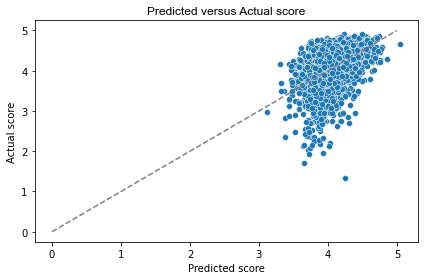

In [41]:
fig, ax = plt.subplots()
sns.scatterplot(y_predv3, y_val)
plt.xlabel('Predicted score')
plt.ylabel('Actual score')
ax.plot(np.linspace(0,5,5), np.linspace(0,5,5), ls="--", c="0.5")
plt.tight_layout()
plt.title('Predicted versus Actual score',family='arial',fontsize=12);
plt.tight_layout()
plt.show;

## Add Payments

In [42]:
features4 = ['ratings_cubed','features','app_ads','payments']

In [43]:
lr4 = LinearRegression()

lr4.fit(X_train[features4], y_train)

y_pred4 = lr4.predict(X_train[features4])
print('R^2 of linear regression on train set: {:.2f}'.format(lr4.score(X_train[features4], y_train)))
print('MSE of linear regression on train set: {:.2f}'.format((mean_squared_error(y_train, y_pred4))))
print('MAE of linear regression on train set: {:.2f}'.format((mean_absolute_error(y_train, y_pred4))))

R^2 of linear regression on train set: 0.24
MSE of linear regression on train set: 0.16
MAE of linear regression on train set: 0.29


In [44]:
y_predv4 = lr4.predict(X_val[features4])
print('R^2 of linear regression on val set: {:.2f}'.format(lr4.score(X_val[features4], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_val, y_predv4))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_predv4))))

R^2 of linear regression on val set: 0.23
MSE of linear regression on val set: 0.14
MAE of linear regression on val set: 0.28


In [45]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features4].columns, lr4.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

ratings_cubed : 0.02
features : 1.12
app_ads : 0.17
payments : 0.03


In [46]:
check4 = X_val.copy()
check4['score'] = y_val
check4['pred'] = lr4.predict(X_val[features4])
check4['resid'] = check4['pred'] - check4['score']

In [47]:
check4.sort_values('resid',ascending = False)

,ratings,free,containsAds,editorsChoice,top_developer,installs_day,updated_days,has_video,year,app_ads,compatibility,updates,features,bugs,payments,use_support,genre_Adventure,genre_Arcade,genre_Art & Design,genre_Auto & Vehicles,genre_Beauty,genre_Board,genre_Books & Reference,genre_Business,genre_Card,genre_Casino,genre_Casual,genre_Comics,genre_Communication,genre_Dating,genre_Education,genre_Entertainment,genre_Finance,genre_Food & Drink,genre_Health & Fitness,genre_House & Home,genre_Libraries & Demo,genre_Lifestyle,genre_Maps & Navigation,genre_Medical,genre_Music & Audio,genre_News & Magazines,genre_Parenting,genre_Personalization,genre_Photography,genre_Productivity,genre_Puzzle,genre_Racing,genre_Role Playing,genre_Shopping,genre_Simulation,genre_Social,genre_Sports,genre_Strategy,genre_Tools,genre_Travel & Local,genre_Trivia,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,ratings_cubed,score,pred,resid
7390,57642.0,1,0,0,0,357.781753,1190,1,2013,0.265720,-0.032281,0.293238,0.136754,0.079100,-0.148733,0.485250,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.628960,1.324779,4.242843,2.918064
17098,3380.0,1,1,0,0,717.360115,1234,0,2017,0.148570,0.064636,0.129360,0.210863,0.273560,0.517600,0.474125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,15.007404,1.958580,3.942641,1.984061
3260,6117.0,1,1,0,0,1430.615165,194,0,2019,-0.208300,0.000000,0.000000,-0.018720,0.000000,-0.149200,0.079050,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.288559,1.696825,3.655170,1.958345
16337,11749.0,1,0,0,0,411.353353,64,0,2014,0.492700,0.156457,0.043175,0.123344,0.188986,0.000000,0.568860,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.733535,2.123090,4.013195,1.890105
16220,11227.0,1,0,0,0,332.889481,6,0,2012,0.308100,0.153818,0.128327,0.167708,0.008767,0.180206,0.299720,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.391743,2.199340,4.031161,1.831821
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10764,54103.0,1,0,0,1,1721.170396,5,0,2019,0.000000,-0.091467,0.000000,-0.179660,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.821648,4.751856,3.835422,-0.916434
11889,9290.0,1,1,0,0,508.646999,676,0,2015,0.201850,0.061106,0.125000,-0.161477,0.304500,0.000000,0.603633,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.021897,4.573735,3.616847,-0.956888
8091,10811.0,1,1,0,1,2941.176471,20,1,2020,-0.144700,0.009000,0.008600,-0.002436,0.140414,-0.743000,0.023767,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.111691,4.684882,3.726530,-0.958352
20655,6253.0,1,1,0,1,456.829603,1473,0,2015,-0.094000,-0.8748

/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


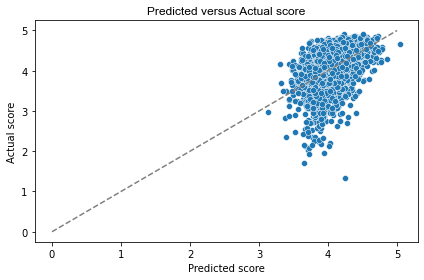

In [48]:
fig, ax = plt.subplots()
sns.scatterplot(y_predv4, y_val)
plt.xlabel('Predicted score')
plt.ylabel('Actual score')
ax.plot(np.linspace(0,5,5), np.linspace(0,5,5), ls="--", c="0.5")
plt.tight_layout()
plt.title('Predicted versus Actual score',family='arial',fontsize=12);
plt.tight_layout()
plt.show;

## Compatibility

In [49]:
features5 = ['ratings_cubed','features','app_ads','payments','compatibility']

In [50]:
lr5 = LinearRegression()

lr5.fit(X_train[features5], y_train)

y_pred5 = lr5.predict(X_train[features5])
print('R^2 of linear regression on train set: {:.2f}'.format(lr5.score(X_train[features5], y_train)))
print('MSE of linear regression on train set: {:.2f}'.format((mean_squared_error(y_train, y_pred5))))
print('MAE of linear regression on train set: {:.2f}'.format((mean_absolute_error(y_train, y_pred5))))

R^2 of linear regression on train set: 0.24
MSE of linear regression on train set: 0.16
MAE of linear regression on train set: 0.29


In [51]:
y_predv5 = lr5.predict(X_val[features5])
print('R^2 of linear regression on val set: {:.2f}'.format(lr5.score(X_val[features5], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_val, y_predv5))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_predv5))))

R^2 of linear regression on val set: 0.23
MSE of linear regression on val set: 0.14
MAE of linear regression on val set: 0.28


In [52]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features5].columns, lr5.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

ratings_cubed : 0.02
features : 1.10
app_ads : 0.17
payments : 0.03
compatibility : 0.04


In [53]:
check5 = X_val.copy()
check5['score'] = y_val
check5['pred'] = lr5.predict(X_val[features5])
check5['resid'] = check5['pred'] - check5['score']

In [54]:
check5.sort_values('resid',ascending = False)

,ratings,free,containsAds,editorsChoice,top_developer,installs_day,updated_days,has_video,year,app_ads,compatibility,updates,features,bugs,payments,use_support,genre_Adventure,genre_Arcade,genre_Art & Design,genre_Auto & Vehicles,genre_Beauty,genre_Board,genre_Books & Reference,genre_Business,genre_Card,genre_Casino,genre_Casual,genre_Comics,genre_Communication,genre_Dating,genre_Education,genre_Entertainment,genre_Finance,genre_Food & Drink,genre_Health & Fitness,genre_House & Home,genre_Libraries & Demo,genre_Lifestyle,genre_Maps & Navigation,genre_Medical,genre_Music & Audio,genre_News & Magazines,genre_Parenting,genre_Personalization,genre_Photography,genre_Productivity,genre_Puzzle,genre_Racing,genre_Role Playing,genre_Shopping,genre_Simulation,genre_Social,genre_Sports,genre_Strategy,genre_Tools,genre_Travel & Local,genre_Trivia,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,ratings_cubed,score,pred,resid
7390,57642.0,1,0,0,0,357.781753,1190,1,2013,0.265720,-0.032281,0.293238,0.136754,0.079100,-0.148733,0.485250,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.628960,1.324779,4.236162,2.911383
17098,3380.0,1,1,0,0,717.360115,1234,0,2017,0.148570,0.064636,0.129360,0.210863,0.273560,0.517600,0.474125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,15.007404,1.958580,3.939569,1.980989
3260,6117.0,1,1,0,0,1430.615165,194,0,2019,-0.208300,0.000000,0.000000,-0.018720,0.000000,-0.149200,0.079050,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.288559,1.696825,3.653657,1.956831
16337,11749.0,1,0,0,0,411.353353,64,0,2014,0.492700,0.156457,0.043175,0.123344,0.188986,0.000000,0.568860,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.733535,2.123090,4.014372,1.891282
16220,11227.0,1,0,0,0,332.889481,6,0,2012,0.308100,0.153818,0.128327,0.167708,0.008767,0.180206,0.299720,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.391743,2.199340,4.031528,1.832188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10764,54103.0,1,0,0,1,1721.170396,5,0,2019,0.000000,-0.091467,0.000000,-0.179660,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.821648,4.751856,3.831437,-0.920419
11889,9290.0,1,1,0,0,508.646999,676,0,2015,0.201850,0.061106,0.125000,-0.161477,0.304500,0.000000,0.603633,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.021897,4.573735,3.619165,-0.954570
8091,10811.0,1,1,0,1,2941.176471,20,1,2020,-0.144700,0.009000,0.008600,-0.002436,0.140414,-0.743000,0.023767,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.111691,4.684882,3.725241,-0.959641
13990,6521.0,1,1,0,1,1703.577513,118,0,2019,0.223238,0.138862

/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


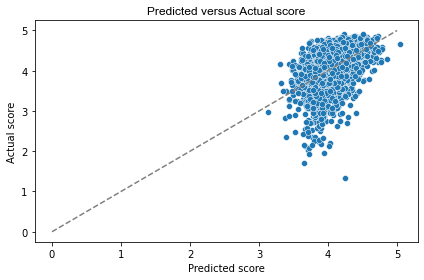

In [55]:
fig, ax = plt.subplots()
sns.scatterplot(y_predv4, y_val)
plt.xlabel('Predicted score')
plt.ylabel('Actual score')
ax.plot(np.linspace(0,5,5), np.linspace(0,5,5), ls="--", c="0.5")
plt.tight_layout()
plt.title('Predicted versus Actual score',family='arial',fontsize=12);
plt.tight_layout()
plt.show;

## Add updated_days

In [56]:
X_train['updated_sqrt'] = X_train['updated_days'] ** 0.25
X_val['updated_sqrt'] = X_val['updated_days'] ** 0.25

<ipython-input-56-ba05ac944f75>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['updated_sqrt'] = X_train['updated_days'] ** 0.25
<ipython-input-56-ba05ac944f75>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val['updated_sqrt'] = X_val['updated_days'] ** 0.25


In [57]:
features6 = ['ratings_cubed','ratings_cubed','features','app_ads','payments','compatibility','updated_sqrt']

In [58]:
lr6 = LinearRegression()

lr6.fit(X_train[features6], y_train)

y_pred6 = lr6.predict(X_train[features6])
print('R^2 of linear regression on train set: {:.2f}'.format(lr6.score(X_train[features6], y_train)))
print('MSE of linear regression on train set: {:.2f}'.format((mean_squared_error(y_train, y_pred6))))
print('MAE of linear regression on train set: {:.2f}'.format((mean_absolute_error(y_train, y_pred6))))

R^2 of linear regression on train set: 0.25
MSE of linear regression on train set: 0.15
MAE of linear regression on train set: 0.29


In [59]:
y_predv6 = lr6.predict(X_val[features6])
print('R^2 of linear regression on val set: {:.2f}'.format(lr6.score(X_val[features6], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_val, y_predv6))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_predv6))))

R^2 of linear regression on val set: 0.25
MSE of linear regression on val set: 0.14
MAE of linear regression on val set: 0.28


In [60]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features6].columns, lr6.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

ratings_cubed : 0.01
ratings_cubed : 0.01
features : 1.07
app_ads : 0.17
payments : 0.04
compatibility : 0.03
updated_sqrt : -0.03


In [61]:
check6 = X_val.copy()
check6['score'] = y_val
check6['pred'] = lr6.predict(X_val[features6])
check6['resid'] = check6['pred'] - check6['score']

In [62]:
check6.sort_values('resid',ascending = False).head(60)

,ratings,free,containsAds,editorsChoice,top_developer,installs_day,updated_days,has_video,year,app_ads,compatibility,updates,features,bugs,payments,use_support,genre_Adventure,genre_Arcade,genre_Art & Design,genre_Auto & Vehicles,genre_Beauty,genre_Board,genre_Books & Reference,genre_Business,genre_Card,genre_Casino,genre_Casual,genre_Comics,genre_Communication,genre_Dating,genre_Education,genre_Entertainment,genre_Finance,genre_Food & Drink,genre_Health & Fitness,genre_House & Home,genre_Libraries & Demo,genre_Lifestyle,genre_Maps & Navigation,genre_Medical,genre_Music & Audio,genre_News & Magazines,genre_Parenting,genre_Personalization,genre_Photography,genre_Productivity,genre_Puzzle,genre_Racing,genre_Role Playing,genre_Shopping,genre_Simulation,genre_Social,genre_Sports,genre_Strategy,genre_Tools,genre_Travel & Local,genre_Trivia,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,ratings_cubed,updated_sqrt,score,pred,resid
7390,57642.0,1,0,0,0,357.781753,1190,1,2013,0.265720,-0.032281,0.293238,0.136754,0.079100,-0.148733,0.485250,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.628960,5.873362,1.324779,4.162936,2.838157
3260,6117.0,1,1,0,0,1430.615165,194,0,2019,-0.208300,0.000000,0.000000,-0.018720,0.000000,-0.149200,0.079050,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.288559,3.732076,1.696825,3.659064,1.962238
17098,3380.0,1,1,0,0,717.360115,1234,0,2017,0.148570,0.064636,0.129360,0.210863,0.273560,0.517600,0.474125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,15.007404,5.926916,1.958580,3.876322,1.917742
16337,11749.0,1,0,0,0,411.353353,64,0,2014,0.492700,0.156457,0.043175,0.123344,0.188986,0.000000,0.568860,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.733535,2.828427,2.123090,4.040594,1.917504
16220,11227.0,1,0,0,0,332.889481,6,0,2012,0.308100,0.153818,0.128327,0.167708,0.008767,0.180206,0.299720,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.391743,1.565085,2.199340,4.094329,1.894989
8013,17878.0,1,1,0,0,259.538022,21,0,2010,-0.139850,0.159100,0.000000,-0.083657,0.212650,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,26.148070,2.140695,1.929050,3.782199,1.853149
14205,7044.0,1,1,0,0,430.292599,41,0,2014,0.186589,0.000000,0.000000,0.105300,0.000000,0.340140,0.427367,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.169309,2.530440,2.187500,3.927767,1.740267
3309,5985.0,1,0,0,0,308.832613,350,0,2012,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.145100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.156051,4.325308,2.030100,3.701074,1.670973
10601,6694.0,1,0,0,0,331.785003,507,0,2012,0.155660,0.260328,-0.210750,0.100294,0.360420,0.000000,0.892700,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


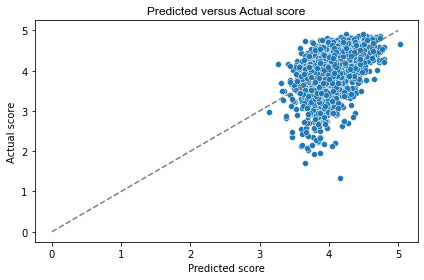

In [63]:
fig, ax = plt.subplots()
sns.scatterplot(y_predv6, y_val)
plt.xlabel('Predicted score')
plt.ylabel('Actual score')
ax.plot(np.linspace(0,5,5), np.linspace(0,5,5), ls="--", c="0.5")
plt.tight_layout()
plt.title('Predicted versus Actual score',family='arial',fontsize=12)
plt.tight_layout()
plt.show;

## Top developer

In [64]:
features7 = ['ratings_cubed','features','app_ads','payments','compatibility','updated_sqrt','top_developer']

In [65]:
lr7 = LinearRegression()

lr7.fit(X_train[features7], y_train)

y_pred7 = lr7.predict(X_train[features7])
print('R^2 of linear regression on train set: {:.2f}'.format(lr7.score(X_train[features7], y_train)))
print('MSE of linear regression on train set: {:.2f}'.format((mean_squared_error(y_train, y_pred7))))
print('MAE of linear regression on train set: {:.2f}'.format((mean_absolute_error(y_train, y_pred7))))

R^2 of linear regression on train set: 0.31
MSE of linear regression on train set: 0.14
MAE of linear regression on train set: 0.28


In [66]:
y_predv7 = lr7.predict(X_val[features7])
print('R^2 of linear regression on val set: {:.2f}'.format(lr7.score(X_val[features7], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_val, y_predv7))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_predv7))))

R^2 of linear regression on val set: 0.31
MSE of linear regression on val set: 0.13
MAE of linear regression on val set: 0.26


In [67]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features7].columns, lr7.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

ratings_cubed : 0.01
features : 1.00
app_ads : 0.16
payments : 0.04
compatibility : 0.02
updated_sqrt : -0.02
top_developer : 0.47


In [68]:
check7 = X_val.copy()
check7['score'] = y_val
check7['pred'] = lr7.predict(X_val[features7])
check7['resid'] = check7['pred'] - check7['score']

In [69]:
check7.sort_values('resid',ascending = False).head()

,ratings,free,containsAds,editorsChoice,top_developer,installs_day,updated_days,has_video,year,app_ads,compatibility,updates,features,bugs,payments,use_support,genre_Adventure,genre_Arcade,genre_Art & Design,genre_Auto & Vehicles,genre_Beauty,genre_Board,genre_Books & Reference,genre_Business,genre_Card,genre_Casino,genre_Casual,genre_Comics,genre_Communication,genre_Dating,genre_Education,genre_Entertainment,genre_Finance,genre_Food & Drink,genre_Health & Fitness,genre_House & Home,genre_Libraries & Demo,genre_Lifestyle,genre_Maps & Navigation,genre_Medical,genre_Music & Audio,genre_News & Magazines,genre_Parenting,genre_Personalization,genre_Photography,genre_Productivity,genre_Puzzle,genre_Racing,genre_Role Playing,genre_Shopping,genre_Simulation,genre_Social,genre_Sports,genre_Strategy,genre_Tools,genre_Travel & Local,genre_Trivia,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,ratings_cubed,updated_sqrt,score,pred,resid
7390,57642.0,1,0,0,0,357.781753,1190,1,2013,0.26572,-0.032281,0.293238,0.136754,0.079100,-0.148733,0.485250,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.628960,5.873362,1.324779,4.115664,2.790885
3260,6117.0,1,1,0,0,1430.615165,194,0,2019,-0.20830,0.000000,0.000000,-0.018720,0.000000,-0.149200,0.079050,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.288559,3.732076,1.696825,3.670329,1.973504
17098,3380.0,1,1,0,0,717.360115,1234,0,2017,0.14857,0.064636,0.129360,0.210863,0.273560,0.517600,0.474125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,15.007404,5.926916,1.958580,3.887210,1.928630
16337,11749.0,1,0,0,0,411.353353,64,0,2014,0.49270,0.156457,0.043175,0.123344,0.188986,0.000000,0.568860,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.733535,2.828427,2.123090,4.013018,1.889928
16220,11227.0,1,0,0,0,332.889481,6,0,2012,0.30810,0.153818,0.128327,0.167708,0.008767,0.180206,0.299720,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.391743,1.565085,2.199340,4.060608,1.861268


/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


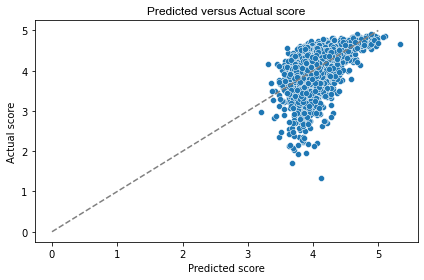

In [70]:
fig, ax = plt.subplots()
sns.scatterplot(y_predv7, y_val)
plt.xlabel('Predicted score')
plt.ylabel('Actual score')
ax.plot(np.linspace(0,5,5), np.linspace(0,5,5), ls="--", c="0.5")
plt.tight_layout()
plt.title('Predicted versus Actual score',family='arial',fontsize=12);
plt.tight_layout()
plt.show;

## Free

In [71]:
features8 = ['ratings_cubed','features','app_ads','payments','compatibility','updated_sqrt','top_developer','free']

In [72]:
lr8 = LinearRegression()

lr8.fit(X_train[features8], y_train)

y_pred8 = lr8.predict(X_train[features8])
print('R^2 of linear regression on train set: {:.2f}'.format(lr8.score(X_train[features8], y_train)))
print('MSE of linear regression on train set: {:.2f}'.format((mean_squared_error(y_train, y_pred8))))
print('MAE of linear regression on train set: {:.2f}'.format((mean_absolute_error(y_train, y_pred8))))

R^2 of linear regression on train set: 0.31
MSE of linear regression on train set: 0.14
MAE of linear regression on train set: 0.28


In [73]:
y_predv8 = lr8.predict(X_val[features8])
print('R^2 of linear regression on val set: {:.2f}'.format(lr8.score(X_val[features8], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_val, y_predv8))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_predv8))))

R^2 of linear regression on val set: 0.31
MSE of linear regression on val set: 0.13
MAE of linear regression on val set: 0.26


In [74]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features8].columns, lr8.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

ratings_cubed : 0.01
features : 1.00
app_ads : 0.16
payments : 0.04
compatibility : 0.02
updated_sqrt : -0.02
top_developer : 0.47
free : 0.13


In [75]:
check8 = X_val.copy()
check8['score'] = y_val
check8['pred'] = lr8.predict(X_val[features8])
check8['resid'] = check8['pred'] - check8['score']

In [76]:
check8.sort_values('resid',ascending = False).head()

,ratings,free,containsAds,editorsChoice,top_developer,installs_day,updated_days,has_video,year,app_ads,compatibility,updates,features,bugs,payments,use_support,genre_Adventure,genre_Arcade,genre_Art & Design,genre_Auto & Vehicles,genre_Beauty,genre_Board,genre_Books & Reference,genre_Business,genre_Card,genre_Casino,genre_Casual,genre_Comics,genre_Communication,genre_Dating,genre_Education,genre_Entertainment,genre_Finance,genre_Food & Drink,genre_Health & Fitness,genre_House & Home,genre_Libraries & Demo,genre_Lifestyle,genre_Maps & Navigation,genre_Medical,genre_Music & Audio,genre_News & Magazines,genre_Parenting,genre_Personalization,genre_Photography,genre_Productivity,genre_Puzzle,genre_Racing,genre_Role Playing,genre_Shopping,genre_Simulation,genre_Social,genre_Sports,genre_Strategy,genre_Tools,genre_Travel & Local,genre_Trivia,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,ratings_cubed,updated_sqrt,score,pred,resid
7390,57642.0,1,0,0,0,357.781753,1190,1,2013,0.26572,-0.032281,0.293238,0.136754,0.079100,-0.148733,0.485250,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.628960,5.873362,1.324779,4.117522,2.792743
3260,6117.0,1,1,0,0,1430.615165,194,0,2019,-0.20830,0.000000,0.000000,-0.018720,0.000000,-0.149200,0.079050,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.288559,3.732076,1.696825,3.669786,1.972961
17098,3380.0,1,1,0,0,717.360115,1234,0,2017,0.14857,0.064636,0.129360,0.210863,0.273560,0.517600,0.474125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,15.007404,5.926916,1.958580,3.886783,1.928203
16337,11749.0,1,0,0,0,411.353353,64,0,2014,0.49270,0.156457,0.043175,0.123344,0.188986,0.000000,0.568860,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.733535,2.828427,2.123090,4.013532,1.890442
16220,11227.0,1,0,0,0,332.889481,6,0,2012,0.30810,0.153818,0.128327,0.167708,0.008767,0.180206,0.299720,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.391743,1.565085,2.199340,4.060782,1.861442


/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


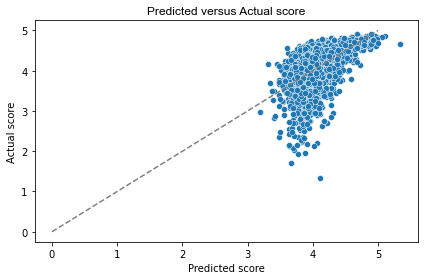

In [77]:
fig, ax = plt.subplots()
sns.scatterplot(y_predv8, y_val)
plt.xlabel('Predicted score')
plt.ylabel('Actual score')
ax.plot(np.linspace(0,5,5), np.linspace(0,5,5), ls="--", c="0.5")
plt.tight_layout()
plt.title('Predicted versus Actual score',family='arial',fontsize=12)
plt.tight_layout()
plt.show;

## News & Magazines

In [78]:
features9 = ['ratings_cubed','features','app_ads','payments','compatibility',
             'updated_sqrt','top_developer','free','genre_News & Magazines']

In [79]:
lr9 = LinearRegression()

lr9.fit(X_train[features9], y_train)

y_pred9 = lr9.predict(X_train[features9])
print('R^2 of linear regression on train set: {:.2f}'.format(lr9.score(X_train[features9], y_train)))
print('MSE of linear regression on train set: {:.2f}'.format((mean_squared_error(y_train, y_pred9))))
print('MAE of linear regression on train set: {:.2f}'.format((mean_absolute_error(y_train, y_pred9))))

R^2 of linear regression on train set: 0.31
MSE of linear regression on train set: 0.14
MAE of linear regression on train set: 0.28


In [80]:
y_predv9 = lr9.predict(X_val[features9])
print('R^2 of linear regression on val set: {:.2f}'.format(lr9.score(X_val[features9], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_val, y_predv9))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_predv9))))

R^2 of linear regression on val set: 0.31
MSE of linear regression on val set: 0.13
MAE of linear regression on val set: 0.26


In [81]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features9].columns, lr9.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

ratings_cubed : 0.01
features : 1.00
app_ads : 0.16
payments : 0.04
compatibility : 0.02
updated_sqrt : -0.02
top_developer : 0.47
free : 0.13
genre_News & Magazines : -0.04


In [82]:
check9 = X_val.copy()
check9['score'] = y_val
check9['pred'] = lr9.predict(X_val[features9])
check9['resid'] = check9['pred'] - check9['score']

In [83]:
check9.sort_values('resid',ascending = False).head()

,ratings,free,containsAds,editorsChoice,top_developer,installs_day,updated_days,has_video,year,app_ads,compatibility,updates,features,bugs,payments,use_support,genre_Adventure,genre_Arcade,genre_Art & Design,genre_Auto & Vehicles,genre_Beauty,genre_Board,genre_Books & Reference,genre_Business,genre_Card,genre_Casino,genre_Casual,genre_Comics,genre_Communication,genre_Dating,genre_Education,genre_Entertainment,genre_Finance,genre_Food & Drink,genre_Health & Fitness,genre_House & Home,genre_Libraries & Demo,genre_Lifestyle,genre_Maps & Navigation,genre_Medical,genre_Music & Audio,genre_News & Magazines,genre_Parenting,genre_Personalization,genre_Photography,genre_Productivity,genre_Puzzle,genre_Racing,genre_Role Playing,genre_Shopping,genre_Simulation,genre_Social,genre_Sports,genre_Strategy,genre_Tools,genre_Travel & Local,genre_Trivia,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,ratings_cubed,updated_sqrt,score,pred,resid
7390,57642.0,1,0,0,0,357.781753,1190,1,2013,0.26572,-0.032281,0.293238,0.136754,0.079100,-0.148733,0.485250,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.628960,5.873362,1.324779,4.117838,2.793059
3260,6117.0,1,1,0,0,1430.615165,194,0,2019,-0.20830,0.000000,0.000000,-0.018720,0.000000,-0.149200,0.079050,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.288559,3.732076,1.696825,3.670891,1.974066
17098,3380.0,1,1,0,0,717.360115,1234,0,2017,0.14857,0.064636,0.129360,0.210863,0.273560,0.517600,0.474125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,15.007404,5.926916,1.958580,3.886678,1.928098
16337,11749.0,1,0,0,0,411.353353,64,0,2014,0.49270,0.156457,0.043175,0.123344,0.188986,0.000000,0.568860,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.733535,2.828427,2.123090,4.013843,1.890753
16220,11227.0,1,0,0,0,332.889481,6,0,2012,0.30810,0.153818,0.128327,0.167708,0.008767,0.180206,0.299720,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.391743,1.565085,2.199340,4.061356,1.862016


/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


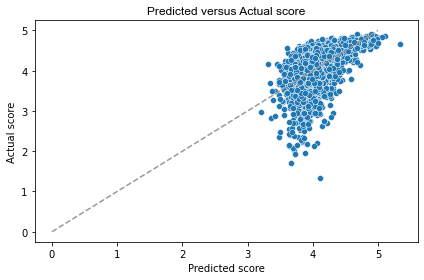

In [84]:
fig, ax = plt.subplots()
sns.scatterplot(y_predv9, y_val)
plt.xlabel('Predicted score')
plt.ylabel('Actual score')
ax.plot(np.linspace(0,5,5), np.linspace(0,5,5), ls="--", c="0.6")
plt.tight_layout()
plt.title('Predicted versus Actual score',family='arial',fontsize=12);
plt.tight_layout()
plt.show;

## Art & Design

In [85]:
features10 = ['ratings_cubed','features','app_ads','payments','compatibility',
             'updated_sqrt','top_developer','free','genre_News & Magazines','genre_Art & Design']

In [86]:
lr10 = LinearRegression()

lr10.fit(X_train[features10], y_train)

y_pred10 = lr10.predict(X_train[features10])
print('R^2 of linear regression on train set: {:.2f}'.format(lr10.score(X_train[features10], y_train)))
print('MSE of linear regression on train set: {:.2f}'.format((mean_squared_error(y_train, y_pred10))))
print('MAE of linear regression on train set: {:.2f}'.format((mean_absolute_error(y_train, y_pred10))))

R^2 of linear regression on train set: 0.31
MSE of linear regression on train set: 0.14
MAE of linear regression on train set: 0.28


In [87]:
y_predv10 = lr10.predict(X_val[features10])
print('R^2 of linear regression on val set: {:.2f}'.format(lr10.score(X_val[features10], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_val, y_predv10))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_predv10))))

R^2 of linear regression on val set: 0.31
MSE of linear regression on val set: 0.13
MAE of linear regression on val set: 0.26


In [88]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features10].columns, lr10.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

ratings_cubed : 0.01
features : 1.00
app_ads : 0.16
payments : 0.04
compatibility : 0.02
updated_sqrt : -0.02
top_developer : 0.47
free : 0.13
genre_News & Magazines : -0.04
genre_Art & Design : -0.01


In [89]:
check10 = X_val.copy()
check10['score'] = y_val
check10['pred'] = lr10.predict(X_val[features10])
check10['resid'] = check10['pred'] - check10['score']

In [90]:
check10.sort_values('resid',ascending = False).head()

,ratings,free,containsAds,editorsChoice,top_developer,installs_day,updated_days,has_video,year,app_ads,compatibility,updates,features,bugs,payments,use_support,genre_Adventure,genre_Arcade,genre_Art & Design,genre_Auto & Vehicles,genre_Beauty,genre_Board,genre_Books & Reference,genre_Business,genre_Card,genre_Casino,genre_Casual,genre_Comics,genre_Communication,genre_Dating,genre_Education,genre_Entertainment,genre_Finance,genre_Food & Drink,genre_Health & Fitness,genre_House & Home,genre_Libraries & Demo,genre_Lifestyle,genre_Maps & Navigation,genre_Medical,genre_Music & Audio,genre_News & Magazines,genre_Parenting,genre_Personalization,genre_Photography,genre_Productivity,genre_Puzzle,genre_Racing,genre_Role Playing,genre_Shopping,genre_Simulation,genre_Social,genre_Sports,genre_Strategy,genre_Tools,genre_Travel & Local,genre_Trivia,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,ratings_cubed,updated_sqrt,score,pred,resid
7390,57642.0,1,0,0,0,357.781753,1190,1,2013,0.26572,-0.032281,0.293238,0.136754,0.079100,-0.148733,0.485250,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.628960,5.873362,1.324779,4.117873,2.793094
3260,6117.0,1,1,0,0,1430.615165,194,0,2019,-0.20830,0.000000,0.000000,-0.018720,0.000000,-0.149200,0.079050,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.288559,3.732076,1.696825,3.670916,1.974091
17098,3380.0,1,1,0,0,717.360115,1234,0,2017,0.14857,0.064636,0.129360,0.210863,0.273560,0.517600,0.474125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,15.007404,5.926916,1.958580,3.886734,1.928154
16337,11749.0,1,0,0,0,411.353353,64,0,2014,0.49270,0.156457,0.043175,0.123344,0.188986,0.000000,0.568860,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.733535,2.828427,2.123090,4.013887,1.890797
16220,11227.0,1,0,0,0,332.889481,6,0,2012,0.30810,0.153818,0.128327,0.167708,0.008767,0.180206,0.299720,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.391743,1.565085,2.199340,4.061394,1.862054


/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


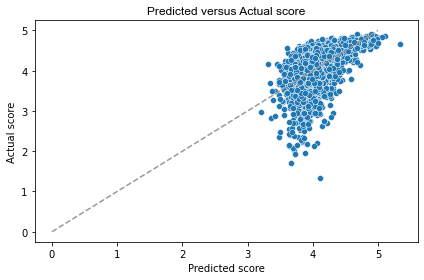

In [91]:
fig, ax = plt.subplots()
sns.scatterplot(y_predv9, y_val)
plt.xlabel('Predicted score')
plt.ylabel('Actual score')
ax.plot(np.linspace(0,5,5), np.linspace(0,5,5), ls="--", c="0.6")
plt.tight_layout()
plt.title('Predicted versus Actual score',family='arial',fontsize=12);
plt.tight_layout()
plt.show;

## Libraries & Demo

In [92]:
features11 = ['ratings_cubed','features','app_ads','payments','compatibility',
             'updated_sqrt','top_developer','free','genre_News & Magazines','genre_Art & Design',
             'genre_Libraries & Demo']

In [93]:
lr11 = LinearRegression()

lr11.fit(X_train[features11], y_train)

y_pred11 = lr11.predict(X_train[features11])
print('R^2 of linear regression on train set: {:.2f}'.format(lr11.score(X_train[features11], y_train)))
print('MSE of linear regression on train set: {:.2f}'.format((mean_squared_error(y_train, y_pred11))))
print('MAE of linear regression on train set: {:.2f}'.format((mean_absolute_error(y_train, y_pred11))))

R^2 of linear regression on train set: 0.31
MSE of linear regression on train set: 0.14
MAE of linear regression on train set: 0.28


In [94]:
y_predv11 = lr11.predict(X_val[features11])
print('R^2 of linear regression on val set: {:.2f}'.format(lr11.score(X_val[features11], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_val, y_predv11))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_predv11))))

R^2 of linear regression on val set: 0.31
MSE of linear regression on val set: 0.13
MAE of linear regression on val set: 0.26


In [95]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features11].columns, lr11.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

ratings_cubed : 0.01
features : 1.00
app_ads : 0.16
payments : 0.04
compatibility : 0.02
updated_sqrt : -0.02
top_developer : 0.47
free : 0.13
genre_News & Magazines : -0.04
genre_Art & Design : -0.01
genre_Libraries & Demo : -0.02


In [96]:
check11 = X_val.copy()
check11['score'] = y_val
check11['pred'] = lr11.predict(X_val[features11])
check11['resid'] = check11['pred'] - check11['score']

In [97]:
check11.sort_values('resid',ascending = False).head()

,ratings,free,containsAds,editorsChoice,top_developer,installs_day,updated_days,has_video,year,app_ads,compatibility,updates,features,bugs,payments,use_support,genre_Adventure,genre_Arcade,genre_Art & Design,genre_Auto & Vehicles,genre_Beauty,genre_Board,genre_Books & Reference,genre_Business,genre_Card,genre_Casino,genre_Casual,genre_Comics,genre_Communication,genre_Dating,genre_Education,genre_Entertainment,genre_Finance,genre_Food & Drink,genre_Health & Fitness,genre_House & Home,genre_Libraries & Demo,genre_Lifestyle,genre_Maps & Navigation,genre_Medical,genre_Music & Audio,genre_News & Magazines,genre_Parenting,genre_Personalization,genre_Photography,genre_Productivity,genre_Puzzle,genre_Racing,genre_Role Playing,genre_Shopping,genre_Simulation,genre_Social,genre_Sports,genre_Strategy,genre_Tools,genre_Travel & Local,genre_Trivia,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,ratings_cubed,updated_sqrt,score,pred,resid
7390,57642.0,1,0,0,0,357.781753,1190,1,2013,0.26572,-0.032281,0.293238,0.136754,0.079100,-0.148733,0.485250,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.628960,5.873362,1.324779,4.117936,2.793158
3260,6117.0,1,1,0,0,1430.615165,194,0,2019,-0.20830,0.000000,0.000000,-0.018720,0.000000,-0.149200,0.079050,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.288559,3.732076,1.696825,3.670976,1.974150
17098,3380.0,1,1,0,0,717.360115,1234,0,2017,0.14857,0.064636,0.129360,0.210863,0.273560,0.517600,0.474125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,15.007404,5.926916,1.958580,3.886764,1.928185
16337,11749.0,1,0,0,0,411.353353,64,0,2014,0.49270,0.156457,0.043175,0.123344,0.188986,0.000000,0.568860,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.733535,2.828427,2.123090,4.013913,1.890823
16220,11227.0,1,0,0,0,332.889481,6,0,2012,0.30810,0.153818,0.128327,0.167708,0.008767,0.180206,0.299720,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.391743,1.565085,2.199340,4.061407,1.862067


/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


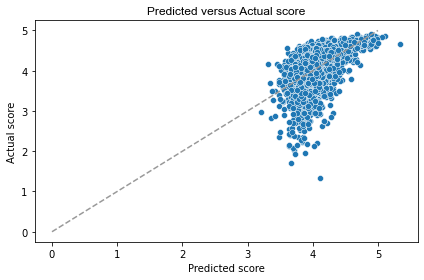

In [98]:
fig, ax = plt.subplots()
sns.scatterplot(y_predv11, y_val)
plt.xlabel('Predicted score')
plt.ylabel('Actual score')
ax.plot(np.linspace(0,5,5), np.linspace(0,5,5), ls="--", c="0.6")
plt.tight_layout()
plt.title('Predicted versus Actual score',family='arial',fontsize=12);
plt.tight_layout()
plt.show;

## Dating

In [99]:
features12 = ['ratings_cubed','features','app_ads','payments','compatibility',
             'updated_sqrt','top_developer','free','genre_News & Magazines','genre_Art & Design',
             'genre_Libraries & Demo','genre_Dating']

In [100]:
lr12 = LinearRegression()

lr12.fit(X_train[features12], y_train)

y_pred12 = lr12.predict(X_train[features12])
print('R^2 of linear regression on train set: {:.2f}'.format(lr12.score(X_train[features12], y_train)))
print('MSE of linear regression on train set: {:.2f}'.format((mean_squared_error(y_train, y_pred12))))
print('MAE of linear regression on train set: {:.2f}'.format((mean_absolute_error(y_train, y_pred12))))

R^2 of linear regression on train set: 0.31
MSE of linear regression on train set: 0.14
MAE of linear regression on train set: 0.28


In [101]:
y_predv12 = lr12.predict(X_val[features12])
print('R^2 of linear regression on val set: {:.2f}'.format(lr12.score(X_val[features12], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_val, y_predv12))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_predv12))))

R^2 of linear regression on val set: 0.31
MSE of linear regression on val set: 0.13
MAE of linear regression on val set: 0.26


In [102]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features12].columns, lr12.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

ratings_cubed : 0.01
features : 1.00
app_ads : 0.16
payments : 0.04
compatibility : 0.02
updated_sqrt : -0.02
top_developer : 0.47
free : 0.13
genre_News & Magazines : -0.05
genre_Art & Design : -0.01
genre_Libraries & Demo : -0.03
genre_Dating : -0.20


In [103]:
check12 = X_val.copy()
check12['score'] = y_val
check12['pred'] = lr12.predict(X_val[features12])
check12['resid'] = check12['pred'] - check12['score']

In [104]:
check12.sort_values('resid',ascending = False).head()

,ratings,free,containsAds,editorsChoice,top_developer,installs_day,updated_days,has_video,year,app_ads,compatibility,updates,features,bugs,payments,use_support,genre_Adventure,genre_Arcade,genre_Art & Design,genre_Auto & Vehicles,genre_Beauty,genre_Board,genre_Books & Reference,genre_Business,genre_Card,genre_Casino,genre_Casual,genre_Comics,genre_Communication,genre_Dating,genre_Education,genre_Entertainment,genre_Finance,genre_Food & Drink,genre_Health & Fitness,genre_House & Home,genre_Libraries & Demo,genre_Lifestyle,genre_Maps & Navigation,genre_Medical,genre_Music & Audio,genre_News & Magazines,genre_Parenting,genre_Personalization,genre_Photography,genre_Productivity,genre_Puzzle,genre_Racing,genre_Role Playing,genre_Shopping,genre_Simulation,genre_Social,genre_Sports,genre_Strategy,genre_Tools,genre_Travel & Local,genre_Trivia,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,ratings_cubed,updated_sqrt,score,pred,resid
7390,57642.0,1,0,0,0,357.781753,1190,1,2013,0.26572,-0.032281,0.293238,0.136754,0.079100,-0.148733,0.485250,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.628960,5.873362,1.324779,4.118581,2.793802
3260,6117.0,1,1,0,0,1430.615165,194,0,2019,-0.20830,0.000000,0.000000,-0.018720,0.000000,-0.149200,0.079050,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.288559,3.732076,1.696825,3.672174,1.975348
17098,3380.0,1,1,0,0,717.360115,1234,0,2017,0.14857,0.064636,0.129360,0.210863,0.273560,0.517600,0.474125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,15.007404,5.926916,1.958580,3.886166,1.927586
16337,11749.0,1,0,0,0,411.353353,64,0,2014,0.49270,0.156457,0.043175,0.123344,0.188986,0.000000,0.568860,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.733535,2.828427,2.123090,4.014977,1.891887
16220,11227.0,1,0,0,0,332.889481,6,0,2012,0.30810,0.153818,0.128327,0.167708,0.008767,0.180206,0.299720,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.391743,1.565085,2.199340,4.062760,1.863420


/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


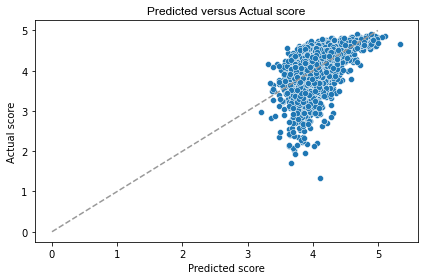

In [105]:
fig, ax = plt.subplots()
sns.scatterplot(y_predv12, y_val)
plt.xlabel('Predicted score')
plt.ylabel('Actual score')
ax.plot(np.linspace(0,5,5), np.linspace(0,5,5), ls="--", c="0.6")
plt.tight_layout()
plt.title('Predicted versus Actual score',family='arial',fontsize=12);
plt.tight_layout()
plt.show;

## Video Players & Editors

In [106]:
features13 = ['ratings_cubed','features','app_ads','payments','compatibility',
             'updated_sqrt','top_developer','free','genre_News & Magazines','genre_Art & Design',
             'genre_Libraries & Demo','genre_Dating','genre_Video Players & Editors']

In [107]:
lr13 = LinearRegression()

lr13.fit(X_train[features13], y_train)

y_pred13 = lr13.predict(X_train[features13])
print('R^2 of linear regression on train set: {:.2f}'.format(lr13.score(X_train[features13], y_train)))
print('MSE of linear regression on train set: {:.2f}'.format((mean_squared_error(y_train, y_pred13))))
print('MAE of linear regression on train set: {:.2f}'.format((mean_absolute_error(y_train, y_pred13))))

R^2 of linear regression on train set: 0.31
MSE of linear regression on train set: 0.14
MAE of linear regression on train set: 0.28


In [108]:
y_predv13 = lr13.predict(X_val[features13])
print('R^2 of linear regression on val set: {:.2f}'.format(lr13.score(X_val[features13], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_val, y_predv13))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_predv13))))

R^2 of linear regression on val set: 0.31
MSE of linear regression on val set: 0.13
MAE of linear regression on val set: 0.26


In [109]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features13].columns, lr13.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

ratings_cubed : 0.01
features : 1.00
app_ads : 0.16
payments : 0.03
compatibility : 0.02
updated_sqrt : -0.02
top_developer : 0.47
free : 0.13
genre_News & Magazines : -0.05
genre_Art & Design : -0.01
genre_Libraries & Demo : -0.03
genre_Dating : -0.21
genre_Video Players & Editors : -0.10


In [110]:
check13 = X_val.copy()
check13['score'] = y_val
check13['pred'] = lr13.predict(X_val[features13])
check13['resid'] = check13['pred'] - check13['score']

In [111]:
check13.sort_values('resid',ascending = False).head()

,ratings,free,containsAds,editorsChoice,top_developer,installs_day,updated_days,has_video,year,app_ads,compatibility,updates,features,bugs,payments,use_support,genre_Adventure,genre_Arcade,genre_Art & Design,genre_Auto & Vehicles,genre_Beauty,genre_Board,genre_Books & Reference,genre_Business,genre_Card,genre_Casino,genre_Casual,genre_Comics,genre_Communication,genre_Dating,genre_Education,genre_Entertainment,genre_Finance,genre_Food & Drink,genre_Health & Fitness,genre_House & Home,genre_Libraries & Demo,genre_Lifestyle,genre_Maps & Navigation,genre_Medical,genre_Music & Audio,genre_News & Magazines,genre_Parenting,genre_Personalization,genre_Photography,genre_Productivity,genre_Puzzle,genre_Racing,genre_Role Playing,genre_Shopping,genre_Simulation,genre_Social,genre_Sports,genre_Strategy,genre_Tools,genre_Travel & Local,genre_Trivia,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,ratings_cubed,updated_sqrt,score,pred,resid
7390,57642.0,1,0,0,0,357.781753,1190,1,2013,0.26572,-0.032281,0.293238,0.136754,0.079100,-0.148733,0.485250,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.628960,5.873362,1.324779,4.120414,2.795635
3260,6117.0,1,1,0,0,1430.615165,194,0,2019,-0.20830,0.000000,0.000000,-0.018720,0.000000,-0.149200,0.079050,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.288559,3.732076,1.696825,3.675210,1.978385
17098,3380.0,1,1,0,0,717.360115,1234,0,2017,0.14857,0.064636,0.129360,0.210863,0.273560,0.517600,0.474125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,15.007404,5.926916,1.958580,3.887567,1.928987
16337,11749.0,1,0,0,0,411.353353,64,0,2014,0.49270,0.156457,0.043175,0.123344,0.188986,0.000000,0.568860,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.733535,2.828427,2.123090,4.016904,1.893814
16220,11227.0,1,0,0,0,332.889481,6,0,2012,0.30810,0.153818,0.128327,0.167708,0.008767,0.180206,0.299720,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.391743,1.565085,2.199340,4.064635,1.865295


/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


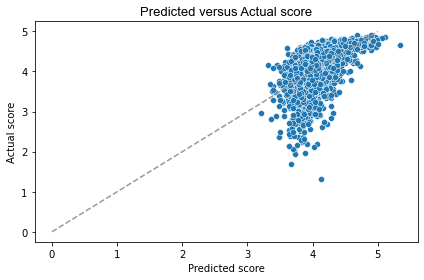

In [112]:
fig, ax = plt.subplots()
sns.scatterplot(y_predv13, y_val)
plt.xlabel('Predicted score')
plt.ylabel('Actual score')
ax.plot(np.linspace(0,5,5), np.linspace(0,5,5), ls="--", c="0.6")
plt.tight_layout()
plt.title('Predicted versus Actual score',family='arial',fontsize=13);
plt.tight_layout()
plt.show;

## Photography

In [113]:
features14 = ['ratings_cubed','features','app_ads','payments','compatibility',
             'updated_sqrt','top_developer','free','genre_News & Magazines','genre_Art & Design',
             'genre_Libraries & Demo','genre_Dating','genre_Video Players & Editors',
             'genre_Photography']

In [114]:
lr14 = LinearRegression()

lr14.fit(X_train[features14], y_train)

y_pred14 = lr14.predict(X_train[features14])
print('R^2 of linear regression on train set: {:.2f}'.format(lr14.score(X_train[features14], y_train)))
print('MSE of linear regression on train set: {:.2f}'.format((mean_squared_error(y_train, y_pred14))))
print('MAE of linear regression on train set: {:.2f}'.format((mean_absolute_error(y_train, y_pred14))))

R^2 of linear regression on train set: 0.31
MSE of linear regression on train set: 0.14
MAE of linear regression on train set: 0.28


In [115]:
y_predv14 = lr14.predict(X_val[features14])
print('R^2 of linear regression on val set: {:.2f}'.format(lr14.score(X_val[features14], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_val, y_predv14))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_predv14))))

R^2 of linear regression on val set: 0.31
MSE of linear regression on val set: 0.13
MAE of linear regression on val set: 0.26


In [116]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features14].columns, lr14.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

ratings_cubed : 0.01
features : 1.00
app_ads : 0.16
payments : 0.03
compatibility : 0.02
updated_sqrt : -0.02
top_developer : 0.47
free : 0.13
genre_News & Magazines : -0.05
genre_Art & Design : -0.01
genre_Libraries & Demo : -0.03
genre_Dating : -0.21
genre_Video Players & Editors : -0.11
genre_Photography : -0.04


In [117]:
check14 = X_val.copy()
check14['score'] = y_val
check14['pred'] = lr14.predict(X_val[features14])
check14['resid'] = check14['pred'] - check14['score']

In [118]:
check14.sort_values('resid',ascending = False).head()

,ratings,free,containsAds,editorsChoice,top_developer,installs_day,updated_days,has_video,year,app_ads,compatibility,updates,features,bugs,payments,use_support,genre_Adventure,genre_Arcade,genre_Art & Design,genre_Auto & Vehicles,genre_Beauty,genre_Board,genre_Books & Reference,genre_Business,genre_Card,genre_Casino,genre_Casual,genre_Comics,genre_Communication,genre_Dating,genre_Education,genre_Entertainment,genre_Finance,genre_Food & Drink,genre_Health & Fitness,genre_House & Home,genre_Libraries & Demo,genre_Lifestyle,genre_Maps & Navigation,genre_Medical,genre_Music & Audio,genre_News & Magazines,genre_Parenting,genre_Personalization,genre_Photography,genre_Productivity,genre_Puzzle,genre_Racing,genre_Role Playing,genre_Shopping,genre_Simulation,genre_Social,genre_Sports,genre_Strategy,genre_Tools,genre_Travel & Local,genre_Trivia,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,ratings_cubed,updated_sqrt,score,pred,resid
7390,57642.0,1,0,0,0,357.781753,1190,1,2013,0.26572,-0.032281,0.293238,0.136754,0.079100,-0.148733,0.485250,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.628960,5.873362,1.324779,4.121887,2.797108
3260,6117.0,1,1,0,0,1430.615165,194,0,2019,-0.20830,0.000000,0.000000,-0.018720,0.000000,-0.149200,0.079050,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.288559,3.732076,1.696825,3.678162,1.981337
17098,3380.0,1,1,0,0,717.360115,1234,0,2017,0.14857,0.064636,0.129360,0.210863,0.273560,0.517600,0.474125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,15.007404,5.926916,1.958580,3.890432,1.931852
16337,11749.0,1,0,0,0,411.353353,64,0,2014,0.49270,0.156457,0.043175,0.123344,0.188986,0.000000,0.568860,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.733535,2.828427,2.123090,4.019045,1.895955
16220,11227.0,1,0,0,0,332.889481,6,0,2012,0.30810,0.153818,0.128327,0.167708,0.008767,0.180206,0.299720,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.391743,1.565085,2.199340,4.066594,1.867255


/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


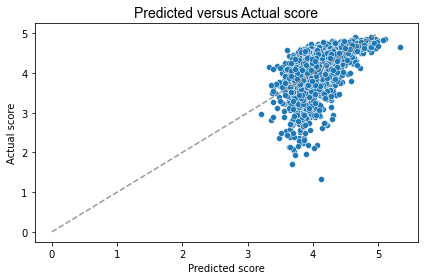

In [119]:
fig, ax = plt.subplots()
sns.scatterplot(y_predv14, y_val)
plt.xlabel('Predicted score')
plt.ylabel('Actual score')
ax.plot(np.linspace(0,5,5), np.linspace(0,5,5), ls="--", c="0.6")
plt.tight_layout()
plt.title('Predicted versus Actual score',family='arial',fontsize=14);
plt.tight_layout()
plt.show;

## Communication

In [120]:
features16 = ['ratings_cubed','features','app_ads','payments','compatibility',
             'updated_sqrt','top_developer','free','genre_News & Magazines','genre_Art & Design',
             'genre_Libraries & Demo','genre_Dating','genre_Video Players & Editors',
             'genre_Photography','genre_Role Playing','genre_Communication']

In [121]:
lr16 = LinearRegression()

lr16.fit(X_train[features16], y_train)

y_pred16 = lr16.predict(X_train[features16])
print('R^2 of linear regression on train set: {:.2f}'.format(lr16.score(X_train[features16], y_train)))
print('MSE of linear regression on train set: {:.2f}'.format((mean_squared_error(y_train, y_pred16))))
print('MAE of linear regression on train set: {:.2f}'.format((mean_absolute_error(y_train, y_pred16))))

R^2 of linear regression on train set: 0.31
MSE of linear regression on train set: 0.14
MAE of linear regression on train set: 0.27


In [122]:
y_predv16 = lr16.predict(X_val[features16])
print('R^2 of linear regression on val set: {:.2f}'.format(lr16.score(X_val[features16], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_val, y_predv16))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_predv16))))

R^2 of linear regression on val set: 0.31
MSE of linear regression on val set: 0.13
MAE of linear regression on val set: 0.26


In [123]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features16].columns, lr16.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

ratings_cubed : 0.01
features : 1.00
app_ads : 0.16
payments : 0.03
compatibility : 0.02
updated_sqrt : -0.03
top_developer : 0.47
free : 0.12
genre_News & Magazines : -0.05
genre_Art & Design : -0.02
genre_Libraries & Demo : -0.03
genre_Dating : -0.21
genre_Video Players & Editors : -0.11
genre_Photography : -0.05
genre_Role Playing : -0.13
genre_Communication : -0.03


In [124]:
check16 = X_val.copy()
check16['score'] = y_val
check16['pred'] = lr16.predict(X_val[features16])
check16['resid'] = check16['pred'] - check16['score']

In [125]:
check16.sort_values('resid',ascending = False).head()

,ratings,free,containsAds,editorsChoice,top_developer,installs_day,updated_days,has_video,year,app_ads,compatibility,updates,features,bugs,payments,use_support,genre_Adventure,genre_Arcade,genre_Art & Design,genre_Auto & Vehicles,genre_Beauty,genre_Board,genre_Books & Reference,genre_Business,genre_Card,genre_Casino,genre_Casual,genre_Comics,genre_Communication,genre_Dating,genre_Education,genre_Entertainment,genre_Finance,genre_Food & Drink,genre_Health & Fitness,genre_House & Home,genre_Libraries & Demo,genre_Lifestyle,genre_Maps & Navigation,genre_Medical,genre_Music & Audio,genre_News & Magazines,genre_Parenting,genre_Personalization,genre_Photography,genre_Productivity,genre_Puzzle,genre_Racing,genre_Role Playing,genre_Shopping,genre_Simulation,genre_Social,genre_Sports,genre_Strategy,genre_Tools,genre_Travel & Local,genre_Trivia,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,ratings_cubed,updated_sqrt,score,pred,resid
7390,57642.0,1,0,0,0,357.781753,1190,1,2013,0.26572,-0.032281,0.293238,0.136754,0.079100,-0.148733,0.485250,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.628960,5.873362,1.324779,4.126773,2.801994
3260,6117.0,1,1,0,0,1430.615165,194,0,2019,-0.20830,0.000000,0.000000,-0.018720,0.000000,-0.149200,0.079050,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.288559,3.732076,1.696825,3.679021,1.982196
17098,3380.0,1,1,0,0,717.360115,1234,0,2017,0.14857,0.064636,0.129360,0.210863,0.273560,0.517600,0.474125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,15.007404,5.926916,1.958580,3.891771,1.933191
16337,11749.0,1,0,0,0,411.353353,64,0,2014,0.49270,0.156457,0.043175,0.123344,0.188986,0.000000,0.568860,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.733535,2.828427,2.123090,4.023877,1.900787
16220,11227.0,1,0,0,0,332.889481,6,0,2012,0.30810,0.153818,0.128327,0.167708,0.008767,0.180206,0.299720,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.391743,1.565085,2.199340,4.072584,1.873244


/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


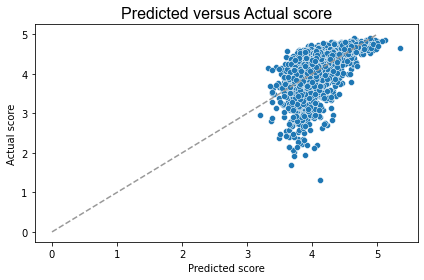

In [126]:
fig, ax = plt.subplots()
sns.scatterplot(y_predv16, y_val)
plt.xlabel('Predicted score')
plt.ylabel('Actual score')
ax.plot(np.linspace(0,5,5), np.linspace(0,5,5), ls="--", c="0.6")
plt.tight_layout()
plt.title('Predicted versus Actual score',family='arial',fontsize=16);
plt.tight_layout()
plt.show;

## Role Playing

In [127]:
features15 = ['ratings_cubed','features','app_ads','payments','compatibility',
             'updated_sqrt','top_developer','free','genre_News & Magazines','genre_Art & Design',
             'genre_Libraries & Demo','genre_Dating','genre_Video Players & Editors',
             'genre_Photography','genre_Role Playing']

In [128]:
lr15 = LinearRegression()

lr15.fit(X_train[features15], y_train)

y_pred15 = lr15.predict(X_train[features15])
print('R^2 of linear regression on train set: {:.2f}'.format(lr15.score(X_train[features15], y_train)))
print('MSE of linear regression on train set: {:.2f}'.format((mean_squared_error(y_train, y_pred15))))
print('MAE of linear regression on train set: {:.2f}'.format((mean_absolute_error(y_train, y_pred15))))

R^2 of linear regression on train set: 0.31
MSE of linear regression on train set: 0.14
MAE of linear regression on train set: 0.27


In [129]:
y_predv15 = lr15.predict(X_val[features15])
print('R^2 of linear regression on val set: {:.2f}'.format(lr15.score(X_val[features15], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_val, y_predv15))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_predv15))))

R^2 of linear regression on val set: 0.31
MSE of linear regression on val set: 0.13
MAE of linear regression on val set: 0.26


In [130]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features15].columns, lr15.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

ratings_cubed : 0.01
features : 1.01
app_ads : 0.16
payments : 0.04
compatibility : 0.02
updated_sqrt : -0.03
top_developer : 0.47
free : 0.12
genre_News & Magazines : -0.05
genre_Art & Design : -0.02
genre_Libraries & Demo : -0.03
genre_Dating : -0.21
genre_Video Players & Editors : -0.11
genre_Photography : -0.05
genre_Role Playing : -0.13


In [131]:
check15 = X_val.copy()
check15['score'] = y_val
check15['pred'] = lr15.predict(X_val[features15])
check15['resid'] = check15['pred'] - check15['score']

In [132]:
check15.sort_values('resid',ascending = False).head()

,ratings,free,containsAds,editorsChoice,top_developer,installs_day,updated_days,has_video,year,app_ads,compatibility,updates,features,bugs,payments,use_support,genre_Adventure,genre_Arcade,genre_Art & Design,genre_Auto & Vehicles,genre_Beauty,genre_Board,genre_Books & Reference,genre_Business,genre_Card,genre_Casino,genre_Casual,genre_Comics,genre_Communication,genre_Dating,genre_Education,genre_Entertainment,genre_Finance,genre_Food & Drink,genre_Health & Fitness,genre_House & Home,genre_Libraries & Demo,genre_Lifestyle,genre_Maps & Navigation,genre_Medical,genre_Music & Audio,genre_News & Magazines,genre_Parenting,genre_Personalization,genre_Photography,genre_Productivity,genre_Puzzle,genre_Racing,genre_Role Playing,genre_Shopping,genre_Simulation,genre_Social,genre_Sports,genre_Strategy,genre_Tools,genre_Travel & Local,genre_Trivia,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,ratings_cubed,updated_sqrt,score,pred,resid
7390,57642.0,1,0,0,0,357.781753,1190,1,2013,0.26572,-0.032281,0.293238,0.136754,0.079100,-0.148733,0.485250,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.628960,5.873362,1.324779,4.126245,2.801466
3260,6117.0,1,1,0,0,1430.615165,194,0,2019,-0.20830,0.000000,0.000000,-0.018720,0.000000,-0.149200,0.079050,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.288559,3.732076,1.696825,3.677709,1.980883
17098,3380.0,1,1,0,0,717.360115,1234,0,2017,0.14857,0.064636,0.129360,0.210863,0.273560,0.517600,0.474125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,15.007404,5.926916,1.958580,3.891597,1.933017
16337,11749.0,1,0,0,0,411.353353,64,0,2014,0.49270,0.156457,0.043175,0.123344,0.188986,0.000000,0.568860,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.733535,2.828427,2.123090,4.023225,1.900135
16220,11227.0,1,0,0,0,332.889481,6,0,2012,0.30810,0.153818,0.128327,0.167708,0.008767,0.180206,0.299720,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.391743,1.565085,2.199340,4.071780,1.872440


/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


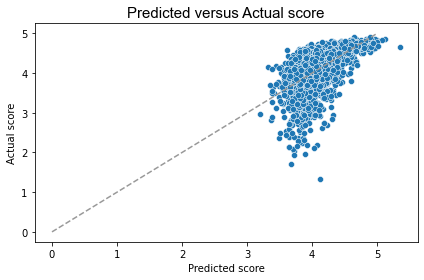

In [133]:
fig, ax = plt.subplots()
sns.scatterplot(y_predv15, y_val)
plt.xlabel('Predicted score')
plt.ylabel('Actual score')
ax.plot(np.linspace(0,5,5), np.linspace(0,5,5), ls="--", c="0.6")
plt.tight_layout()
plt.title('Predicted versus Actual score',family='arial',fontsize=15);
plt.tight_layout()
plt.show;

## Entertainment

In [134]:
features16 = ['ratings_cubed','features','app_ads','payments','compatibility',
             'updated_sqrt','top_developer','free','genre_News & Magazines','genre_Art & Design',
             'genre_Libraries & Demo','genre_Dating','genre_Video Players & Editors',
             'genre_Photography','genre_Role Playing','genre_Entertainment']

In [135]:
lr16 = LinearRegression()

lr16.fit(X_train[features16], y_train)

y_pred16 = lr16.predict(X_train[features16])
print('R^2 of linear regression on train set: {:.2f}'.format(lr16.score(X_train[features16], y_train)))
print('MSE of linear regression on train set: {:.2f}'.format((mean_squared_error(y_train, y_pred16))))
print('MAE of linear regression on train set: {:.2f}'.format((mean_absolute_error(y_train, y_pred16))))

R^2 of linear regression on train set: 0.31
MSE of linear regression on train set: 0.14
MAE of linear regression on train set: 0.27


In [136]:
y_predv16 = lr16.predict(X_val[features16])
print('R^2 of linear regression on val set: {:.2f}'.format(lr16.score(X_val[features16], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_val, y_predv16))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_predv16))))

R^2 of linear regression on val set: 0.32
MSE of linear regression on val set: 0.13
MAE of linear regression on val set: 0.26


In [137]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features16].columns, lr16.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

ratings_cubed : 0.01
features : 1.01
app_ads : 0.16
payments : 0.03
compatibility : 0.02
updated_sqrt : -0.03
top_developer : 0.46
free : 0.13
genre_News & Magazines : -0.06
genre_Art & Design : -0.02
genre_Libraries & Demo : -0.04
genre_Dating : -0.22
genre_Video Players & Editors : -0.12
genre_Photography : -0.05
genre_Role Playing : -0.13
genre_Entertainment : -0.09


In [138]:
check16 = X_val.copy()
check16['score'] = y_val
check16['pred'] = lr16.predict(X_val[features16])
check16['resid'] = check16['pred'] - check16['score']

In [139]:
check16.sort_values('resid',ascending = False).head()

,ratings,free,containsAds,editorsChoice,top_developer,installs_day,updated_days,has_video,year,app_ads,compatibility,updates,features,bugs,payments,use_support,genre_Adventure,genre_Arcade,genre_Art & Design,genre_Auto & Vehicles,genre_Beauty,genre_Board,genre_Books & Reference,genre_Business,genre_Card,genre_Casino,genre_Casual,genre_Comics,genre_Communication,genre_Dating,genre_Education,genre_Entertainment,genre_Finance,genre_Food & Drink,genre_Health & Fitness,genre_House & Home,genre_Libraries & Demo,genre_Lifestyle,genre_Maps & Navigation,genre_Medical,genre_Music & Audio,genre_News & Magazines,genre_Parenting,genre_Personalization,genre_Photography,genre_Productivity,genre_Puzzle,genre_Racing,genre_Role Playing,genre_Shopping,genre_Simulation,genre_Social,genre_Sports,genre_Strategy,genre_Tools,genre_Travel & Local,genre_Trivia,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,ratings_cubed,updated_sqrt,score,pred,resid
7390,57642.0,1,0,0,0,357.781753,1190,1,2013,0.26572,-0.032281,0.293238,0.136754,0.079100,-0.148733,0.485250,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.628960,5.873362,1.324779,4.130638,2.805859
3260,6117.0,1,1,0,0,1430.615165,194,0,2019,-0.20830,0.000000,0.000000,-0.018720,0.000000,-0.149200,0.079050,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.288559,3.732076,1.696825,3.686446,1.989620
16337,11749.0,1,0,0,0,411.353353,64,0,2014,0.49270,0.156457,0.043175,0.123344,0.188986,0.000000,0.568860,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.733535,2.828427,2.123090,4.029814,1.906724
16220,11227.0,1,0,0,0,332.889481,6,0,2012,0.30810,0.153818,0.128327,0.167708,0.008767,0.180206,0.299720,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.391743,1.565085,2.199340,4.078493,1.879153
17098,3380.0,1,1,0,0,717.360115,1234,0,2017,0.14857,0.064636,0.129360,0.210863,0.273560,0.517600,0.474125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,15.007404,5.926916,1.958580,3.809301,1.850721


/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


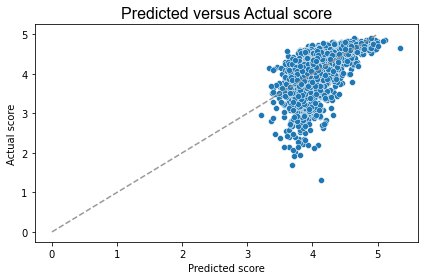

In [140]:
fig, ax = plt.subplots()
sns.scatterplot(y_predv16, y_val)
plt.xlabel('Predicted score')
plt.ylabel('Actual score')
ax.plot(np.linspace(0,5,5), np.linspace(0,5,5), ls="--", c="0.6")
plt.tight_layout()
plt.title('Predicted versus Actual score',family='arial',fontsize=16);
plt.tight_layout()
plt.show;

## Simulation

In [141]:
features17 = ['ratings_cubed','features','app_ads','payments','compatibility',
             'updated_sqrt','top_developer','free','genre_News & Magazines','genre_Art & Design',
             'genre_Libraries & Demo','genre_Dating','genre_Video Players & Editors',
             'genre_Photography','genre_Role Playing','genre_Entertainment',
             'genre_Simulation']

In [142]:
lr17 = LinearRegression()

lr17.fit(X_train[features17], y_train)

y_pred17 = lr17.predict(X_train[features17])
print('R^2 of linear regression on train set: {:.2f}'.format(lr17.score(X_train[features17], y_train)))
print('MSE of linear regression on train set: {:.2f}'.format((mean_squared_error(y_train, y_pred17))))
print('MAE of linear regression on train set: {:.2f}'.format((mean_absolute_error(y_train, y_pred17))))

R^2 of linear regression on train set: 0.32
MSE of linear regression on train set: 0.14
MAE of linear regression on train set: 0.27


In [143]:
y_predv17 = lr17.predict(X_val[features17])
print('R^2 of linear regression on val set: {:.2f}'.format(lr17.score(X_val[features17], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_val, y_predv17))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_predv17))))

R^2 of linear regression on val set: 0.32
MSE of linear regression on val set: 0.13
MAE of linear regression on val set: 0.26


In [144]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features17].columns, lr17.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

ratings_cubed : 0.01
features : 0.99
app_ads : 0.16
payments : 0.04
compatibility : 0.02
updated_sqrt : -0.02
top_developer : 0.46
free : 0.12
genre_News & Magazines : -0.07
genre_Art & Design : -0.03
genre_Libraries & Demo : -0.05
genre_Dating : -0.23
genre_Video Players & Editors : -0.13
genre_Photography : -0.06
genre_Role Playing : -0.15
genre_Entertainment : -0.10
genre_Simulation : -0.14


In [145]:
check17 = X_val.copy()
check17['score'] = y_val
check17['pred'] = lr17.predict(X_val[features17])
check17['resid'] = check17['pred'] - check17['score']

In [146]:
check17.sort_values('resid',ascending = False).head()

,ratings,free,containsAds,editorsChoice,top_developer,installs_day,updated_days,has_video,year,app_ads,compatibility,updates,features,bugs,payments,use_support,genre_Adventure,genre_Arcade,genre_Art & Design,genre_Auto & Vehicles,genre_Beauty,genre_Board,genre_Books & Reference,genre_Business,genre_Card,genre_Casino,genre_Casual,genre_Comics,genre_Communication,genre_Dating,genre_Education,genre_Entertainment,genre_Finance,genre_Food & Drink,genre_Health & Fitness,genre_House & Home,genre_Libraries & Demo,genre_Lifestyle,genre_Maps & Navigation,genre_Medical,genre_Music & Audio,genre_News & Magazines,genre_Parenting,genre_Personalization,genre_Photography,genre_Productivity,genre_Puzzle,genre_Racing,genre_Role Playing,genre_Shopping,genre_Simulation,genre_Social,genre_Sports,genre_Strategy,genre_Tools,genre_Travel & Local,genre_Trivia,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,ratings_cubed,updated_sqrt,score,pred,resid
7390,57642.0,1,0,0,0,357.781753,1190,1,2013,0.26572,-0.032281,0.293238,0.136754,0.079100,-0.148733,0.485250,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.628960,5.873362,1.324779,4.145161,2.820382
3260,6117.0,1,1,0,0,1430.615165,194,0,2019,-0.20830,0.000000,0.000000,-0.018720,0.000000,-0.149200,0.079050,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.288559,3.732076,1.696825,3.699985,2.003160
16337,11749.0,1,0,0,0,411.353353,64,0,2014,0.49270,0.156457,0.043175,0.123344,0.188986,0.000000,0.568860,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.733535,2.828427,2.123090,4.040421,1.917331
16220,11227.0,1,0,0,0,332.889481,6,0,2012,0.30810,0.153818,0.128327,0.167708,0.008767,0.180206,0.299720,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.391743,1.565085,2.199340,4.087572,1.888232
17098,3380.0,1,1,0,0,717.360115,1234,0,2017,0.14857,0.064636,0.129360,0.210863,0.273560,0.517600,0.474125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,15.007404,5.926916,1.958580,3.816916,1.858336


/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


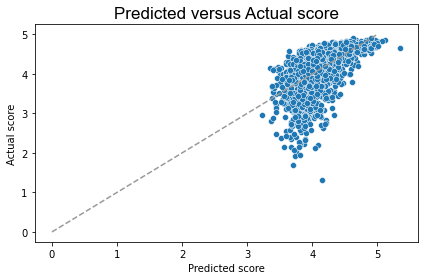

In [147]:
fig, ax = plt.subplots()
sns.scatterplot(y_predv17, y_val)
plt.xlabel('Predicted score')
plt.ylabel('Actual score')
ax.plot(np.linspace(0,5,5), np.linspace(0,5,5), ls="--", c="0.6")
plt.tight_layout()
plt.title('Predicted versus Actual score',family='arial',fontsize=17);
plt.tight_layout()
plt.show;

## Arcade

In [148]:
features18 = ['ratings_cubed','features','app_ads','payments','compatibility',
             'updated_sqrt','top_developer','free','genre_News & Magazines','genre_Art & Design',
             'genre_Libraries & Demo','genre_Dating','genre_Video Players & Editors',
             'genre_Photography','genre_Role Playing','genre_Entertainment',
             'genre_Simulation','genre_Arcade']

In [149]:
lr18 = LinearRegression()

lr18.fit(X_train[features18], y_train)

y_pred18 = lr18.predict(X_train[features18])
print('R^2 of linear regression on train set: {:.2f}'.format(lr18.score(X_train[features18], y_train)))
print('MSE of linear regression on train set: {:.2f}'.format((mean_squared_error(y_train, y_pred18))))
print('MAE of linear regression on train set: {:.2f}'.format((mean_absolute_error(y_train, y_pred18))))

R^2 of linear regression on train set: 0.32
MSE of linear regression on train set: 0.14
MAE of linear regression on train set: 0.27


In [150]:
y_predv18 = lr18.predict(X_val[features18])
print('R^2 of linear regression on val set: {:.2f}'.format(lr18.score(X_val[features18], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_val, y_predv18))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_predv18))))

R^2 of linear regression on val set: 0.32
MSE of linear regression on val set: 0.13
MAE of linear regression on val set: 0.26


In [151]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features18].columns, lr18.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

ratings_cubed : 0.01
features : 0.99
app_ads : 0.16
payments : 0.04
compatibility : 0.02
updated_sqrt : -0.02
top_developer : 0.46
free : 0.12
genre_News & Magazines : -0.07
genre_Art & Design : -0.03
genre_Libraries & Demo : -0.05
genre_Dating : -0.23
genre_Video Players & Editors : -0.13
genre_Photography : -0.06
genre_Role Playing : -0.15
genre_Entertainment : -0.10
genre_Simulation : -0.14
genre_Arcade : -0.02


In [152]:
check18 = X_val.copy()
check18['score'] = y_val
check18['pred'] = lr18.predict(X_val[features18])
check18['resid'] = check18['pred'] - check18['score']

In [153]:
check18.sort_values('resid',ascending = False).head()

,ratings,free,containsAds,editorsChoice,top_developer,installs_day,updated_days,has_video,year,app_ads,compatibility,updates,features,bugs,payments,use_support,genre_Adventure,genre_Arcade,genre_Art & Design,genre_Auto & Vehicles,genre_Beauty,genre_Board,genre_Books & Reference,genre_Business,genre_Card,genre_Casino,genre_Casual,genre_Comics,genre_Communication,genre_Dating,genre_Education,genre_Entertainment,genre_Finance,genre_Food & Drink,genre_Health & Fitness,genre_House & Home,genre_Libraries & Demo,genre_Lifestyle,genre_Maps & Navigation,genre_Medical,genre_Music & Audio,genre_News & Magazines,genre_Parenting,genre_Personalization,genre_Photography,genre_Productivity,genre_Puzzle,genre_Racing,genre_Role Playing,genre_Shopping,genre_Simulation,genre_Social,genre_Sports,genre_Strategy,genre_Tools,genre_Travel & Local,genre_Trivia,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,ratings_cubed,updated_sqrt,score,pred,resid
7390,57642.0,1,0,0,0,357.781753,1190,1,2013,0.26572,-0.032281,0.293238,0.136754,0.079100,-0.148733,0.485250,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.628960,5.873362,1.324779,4.128966,2.804187
3260,6117.0,1,1,0,0,1430.615165,194,0,2019,-0.20830,0.000000,0.000000,-0.018720,0.000000,-0.149200,0.079050,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.288559,3.732076,1.696825,3.700593,2.003768
16337,11749.0,1,0,0,0,411.353353,64,0,2014,0.49270,0.156457,0.043175,0.123344,0.188986,0.000000,0.568860,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.733535,2.828427,2.123090,4.041076,1.917986
16220,11227.0,1,0,0,0,332.889481,6,0,2012,0.30810,0.153818,0.128327,0.167708,0.008767,0.180206,0.299720,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.391743,1.565085,2.199340,4.088061,1.888722
17098,3380.0,1,1,0,0,717.360115,1234,0,2017,0.14857,0.064636,0.129360,0.210863,0.273560,0.517600,0.474125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,15.007404,5.926916,1.958580,3.817309,1.858729


/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


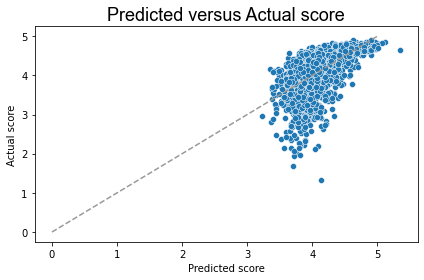

In [154]:
fig, ax = plt.subplots()
sns.scatterplot(y_predv18, y_val)
plt.xlabel('Predicted score')
plt.ylabel('Actual score')
ax.plot(np.linspace(0,5,5), np.linspace(0,5,5), ls="--", c="0.6")
plt.tight_layout()
plt.title('Predicted versus Actual score',family='arial',fontsize=18);
plt.tight_layout()
plt.show;

## Free * Simulation

In [155]:
X_train['free_simulation'] = X_train['free'] * X_train['genre_Simulation']
X_val['free_simulation'] = X_val['free'] * X_val['genre_Simulation']

<ipython-input-155-85b1651741fb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['free_simulation'] = X_train['free'] * X_train['genre_Simulation']
<ipython-input-155-85b1651741fb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val['free_simulation'] = X_val['free'] * X_val['genre_Simulation']


In [156]:
features19 = ['ratings_cubed','features','app_ads','payments','compatibility',
             'updated_sqrt','top_developer','free','genre_News & Magazines','genre_Art & Design',
             'genre_Libraries & Demo','genre_Dating','genre_Video Players & Editors',
             'genre_Photography','genre_Role Playing','genre_Entertainment',
             'genre_Simulation','genre_Arcade','free_simulation']

In [157]:
lr19 = LinearRegression()

lr19.fit(X_train[features19], y_train)

y_pred19 = lr19.predict(X_train[features19])
print('R^2 of linear regression on train set: {:.2f}'.format(lr19.score(X_train[features19], y_train)))
print('MSE of linear regression on train set: {:.2f}'.format((mean_squared_error(y_train, y_pred19))))
print('MAE of linear regression on train set: {:.2f}'.format((mean_absolute_error(y_train, y_pred19))))

R^2 of linear regression on train set: 0.32
MSE of linear regression on train set: 0.14
MAE of linear regression on train set: 0.27


In [158]:
y_predv19 = lr19.predict(X_val[features19])
print('R^2 of linear regression on val set: {:.2f}'.format(lr19.score(X_val[features19], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_val, y_predv19))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_predv19))))

R^2 of linear regression on val set: 0.32
MSE of linear regression on val set: 0.13
MAE of linear regression on val set: 0.26


In [159]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features19].columns, lr19.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

ratings_cubed : 0.01
features : 0.99
app_ads : 0.16
payments : 0.04
compatibility : 0.02
updated_sqrt : -0.02
top_developer : 0.46
free : 0.13
genre_News & Magazines : -0.07
genre_Art & Design : -0.03
genre_Libraries & Demo : -0.05
genre_Dating : -0.23
genre_Video Players & Editors : -0.13
genre_Photography : -0.06
genre_Role Playing : -0.15
genre_Entertainment : -0.10
genre_Simulation : 0.02
genre_Arcade : -0.02
free_simulation : -0.16


In [160]:
check19 = X_val.copy()
check19['score'] = y_val
check19['pred'] = lr19.predict(X_val[features19])
check19['resid'] = check19['pred'] - check19['score']

In [161]:
check19.sort_values('resid',ascending = False).head()

,ratings,free,containsAds,editorsChoice,top_developer,installs_day,updated_days,has_video,year,app_ads,compatibility,updates,features,bugs,payments,use_support,genre_Adventure,genre_Arcade,genre_Art & Design,genre_Auto & Vehicles,genre_Beauty,genre_Board,genre_Books & Reference,genre_Business,genre_Card,genre_Casino,genre_Casual,genre_Comics,genre_Communication,genre_Dating,genre_Education,genre_Entertainment,genre_Finance,genre_Food & Drink,genre_Health & Fitness,genre_House & Home,genre_Libraries & Demo,genre_Lifestyle,genre_Maps & Navigation,genre_Medical,genre_Music & Audio,genre_News & Magazines,genre_Parenting,genre_Personalization,genre_Photography,genre_Productivity,genre_Puzzle,genre_Racing,genre_Role Playing,genre_Shopping,genre_Simulation,genre_Social,genre_Sports,genre_Strategy,genre_Tools,genre_Travel & Local,genre_Trivia,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,ratings_cubed,updated_sqrt,free_simulation,score,pred,resid
7390,57642.0,1,0,0,0,357.781753,1190,1,2013,0.26572,-0.032281,0.293238,0.136754,0.079100,-0.148733,0.485250,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.628960,5.873362,0.0,1.324779,4.129049,2.804270
3260,6117.0,1,1,0,0,1430.615165,194,0,2019,-0.20830,0.000000,0.000000,-0.018720,0.000000,-0.149200,0.079050,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.288559,3.732076,0.0,1.696825,3.700680,2.003855
16337,11749.0,1,0,0,0,411.353353,64,0,2014,0.49270,0.156457,0.043175,0.123344,0.188986,0.000000,0.568860,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.733535,2.828427,0.0,2.123090,4.041100,1.918010
16220,11227.0,1,0,0,0,332.889481,6,0,2012,0.30810,0.153818,0.128327,0.167708,0.008767,0.180206,0.299720,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.391743,1.565085,0.0,2.199340,4.088135,1.888795
17098,3380.0,1,1,0,0,717.360115,1234,0,2017,0.14857,0.064636,0.129360,0.210863,0.273560,0.517600,0.474125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,15.007404,5.926916,0.0,1.958580,3.817380,1.858800


/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


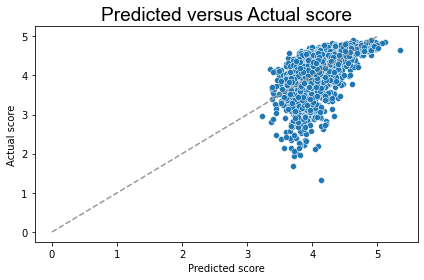

In [162]:
fig, ax = plt.subplots()
sns.scatterplot(y_predv19, y_val)
plt.xlabel('Predicted score')
plt.ylabel('Actual score')
ax.plot(np.linspace(0,5,5), np.linspace(0,5,5), ls="--", c="0.6")
plt.tight_layout()
plt.title('Predicted versus Actual score',family='arial',fontsize=19);
plt.tight_layout()
plt.show;

## containsAds * Adventure

In [163]:
X_train['ads_adventure'] = X_train['containsAds'] * X_train['genre_Adventure']
X_val['ads_adventure'] = X_val['containsAds'] * X_val['genre_Adventure']

<ipython-input-163-44dfd200d3df>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['ads_adventure'] = X_train['containsAds'] * X_train['genre_Adventure']
<ipython-input-163-44dfd200d3df>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val['ads_adventure'] = X_val['containsAds'] * X_val['genre_Adventure']


In [164]:
features22 = ['ratings_cubed','features','app_ads','payments',
             'updated_sqrt','top_developer','free','genre_News & Magazines','genre_Art & Design',
             'genre_Libraries & Demo','genre_Dating','genre_Video Players & Editors',
             'genre_Photography','genre_Role Playing','genre_Entertainment',
             'genre_Simulation','genre_Arcade','free_simulation','ads_adventure']

In [165]:
lr22 = LinearRegression()

lr22.fit(X_train[features22], y_train)

y_pred22 = lr22.predict(X_train[features22])
print('R^2 of linear regression on train set: {:.2f}'.format(lr22.score(X_train[features22], y_train)))
print('MSE of linear regression on train set: {:.2f}'.format((mean_squared_error(y_train, y_pred22))))
print('MAE of linear regression on train set: {:.2f}'.format((mean_absolute_error(y_train, y_pred22))))

R^2 of linear regression on train set: 0.32
MSE of linear regression on train set: 0.14
MAE of linear regression on train set: 0.27


In [166]:
y_predv22 = lr22.predict(X_val[features22])
print('R^2 of linear regression on val set: {:.2f}'.format(lr22.score(X_val[features22], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_val, y_predv22))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_predv22))))

R^2 of linear regression on val set: 0.32
MSE of linear regression on val set: 0.13
MAE of linear regression on val set: 0.26


In [167]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features22].columns, lr22.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

ratings_cubed : 0.01
features : 1.00
app_ads : 0.16
payments : 0.04
updated_sqrt : -0.02
top_developer : 0.46
free : 0.13
genre_News & Magazines : -0.08
genre_Art & Design : -0.04
genre_Libraries & Demo : -0.06
genre_Dating : -0.23
genre_Video Players & Editors : -0.13
genre_Photography : -0.07
genre_Role Playing : -0.15
genre_Entertainment : -0.11
genre_Simulation : 0.01
genre_Arcade : -0.02
free_simulation : -0.16
ads_adventure : -0.12


In [168]:
check22 = X_val.copy()
check22['score'] = y_val
check22['pred'] = lr22.predict(X_val[features22])
check22['resid'] = check22['pred'] - check22['score']

In [169]:
check22.sort_values('resid',ascending = False).head()

,ratings,free,containsAds,editorsChoice,top_developer,installs_day,updated_days,has_video,year,app_ads,compatibility,updates,features,bugs,payments,use_support,genre_Adventure,genre_Arcade,genre_Art & Design,genre_Auto & Vehicles,genre_Beauty,genre_Board,genre_Books & Reference,genre_Business,genre_Card,genre_Casino,genre_Casual,genre_Comics,genre_Communication,genre_Dating,genre_Education,genre_Entertainment,genre_Finance,genre_Food & Drink,genre_Health & Fitness,genre_House & Home,genre_Libraries & Demo,genre_Lifestyle,genre_Maps & Navigation,genre_Medical,genre_Music & Audio,genre_News & Magazines,genre_Parenting,genre_Personalization,genre_Photography,genre_Productivity,genre_Puzzle,genre_Racing,genre_Role Playing,genre_Shopping,genre_Simulation,genre_Social,genre_Sports,genre_Strategy,genre_Tools,genre_Travel & Local,genre_Trivia,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,ratings_cubed,updated_sqrt,free_simulation,ads_adventure,score,pred,resid
7390,57642.0,1,0,0,0,357.781753,1190,1,2013,0.26572,-0.032281,0.293238,0.136754,0.079100,-0.148733,0.485250,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.628960,5.873362,0.0,0.0,1.324779,4.132706,2.807927
3260,6117.0,1,1,0,0,1430.615165,194,0,2019,-0.20830,0.000000,0.000000,-0.018720,0.000000,-0.149200,0.079050,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.288559,3.732076,0.0,0.0,1.696825,3.705562,2.008736
16337,11749.0,1,0,0,0,411.353353,64,0,2014,0.49270,0.156457,0.043175,0.123344,0.188986,0.000000,0.568860,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.733535,2.828427,0.0,0.0,2.123090,4.043805,1.920715
16220,11227.0,1,0,0,0,332.889481,6,0,2012,0.30810,0.153818,0.128327,0.167708,0.008767,0.180206,0.299720,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.391743,1.565085,0.0,0.0,2.199340,4.091337,1.891997
17098,3380.0,1,1,0,0,717.360115,1234,0,2017,0.14857,0.064636,0.129360,0.210863,0.273560,0.517600,0.474125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,15.007404,5.926916,0.0,0.0,1.958580,3.819974,1.861394


/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


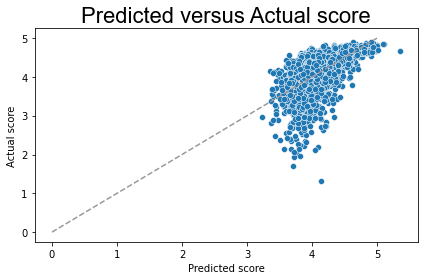

In [170]:
fig, ax = plt.subplots()
sns.scatterplot(y_predv22, y_val)
plt.xlabel('Predicted score')
plt.ylabel('Actual score')
ax.plot(np.linspace(0,5,5), np.linspace(0,5,5), ls="--", c="0.6")
plt.tight_layout()
plt.title('Predicted versus Actual score',family='arial',fontsize=22);
plt.tight_layout()
plt.show;

## containsAds * Beauty

In [171]:
X_train['ads_beauty'] = X_train['containsAds'] * X_train['genre_Beauty']
X_val['ads_beauty'] = X_val['containsAds'] * X_val['genre_Beauty']

<ipython-input-171-768fc33d702d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['ads_beauty'] = X_train['containsAds'] * X_train['genre_Beauty']
<ipython-input-171-768fc33d702d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val['ads_beauty'] = X_val['containsAds'] * X_val['genre_Beauty']


In [172]:
features23 = ['ratings_cubed','features','app_ads','payments','compatibility',
             'updated_sqrt','top_developer','free','genre_News & Magazines','genre_Art & Design',
             'genre_Libraries & Demo','genre_Dating','genre_Video Players & Editors',
             'genre_Photography','genre_Role Playing','genre_Entertainment',
             'genre_Simulation','genre_Arcade','free_simulation',
             'ads_adventure','ads_beauty']

In [173]:
lr23 = LinearRegression()

lr23.fit(X_train[features23], y_train)

y_pred23 = lr23.predict(X_train[features23])
print('R^2 of linear regression on train set: {:.2f}'.format(lr23.score(X_train[features23], y_train)))
print('MSE of linear regression on train set: {:.2f}'.format((mean_squared_error(y_train, y_pred23))))
print('MAE of linear regression on train set: {:.2f}'.format((mean_absolute_error(y_train, y_pred23))))

R^2 of linear regression on train set: 0.32
MSE of linear regression on train set: 0.14
MAE of linear regression on train set: 0.27


In [174]:
y_predv23 = lr23.predict(X_val[features23])
print('R^2 of linear regression on val set: {:.2f}'.format(lr23.score(X_val[features23], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_val, y_predv23))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_predv23))))

R^2 of linear regression on val set: 0.32
MSE of linear regression on val set: 0.13
MAE of linear regression on val set: 0.26


In [175]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features23].columns, lr23.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

ratings_cubed : 0.01
features : 0.99
app_ads : 0.16
payments : 0.04
compatibility : 0.02
updated_sqrt : -0.02
top_developer : 0.45
free : 0.13
genre_News & Magazines : -0.07
genre_Art & Design : -0.04
genre_Libraries & Demo : -0.06
genre_Dating : -0.23
genre_Video Players & Editors : -0.13
genre_Photography : -0.07
genre_Role Playing : -0.15
genre_Entertainment : -0.11
genre_Simulation : 0.01
genre_Arcade : -0.02
free_simulation : -0.16
ads_adventure : -0.12
ads_beauty : -0.17


In [176]:
check23 = X_val.copy()
check23['score'] = y_val
check23['pred'] = lr23.predict(X_val[features23])
check23['resid'] = check23['pred'] - check23['score']

In [177]:
check23.sort_values('resid',ascending = False).head()

,ratings,free,containsAds,editorsChoice,top_developer,installs_day,updated_days,has_video,year,app_ads,compatibility,updates,features,bugs,payments,use_support,genre_Adventure,genre_Arcade,genre_Art & Design,genre_Auto & Vehicles,genre_Beauty,genre_Board,genre_Books & Reference,genre_Business,genre_Card,genre_Casino,genre_Casual,genre_Comics,genre_Communication,genre_Dating,genre_Education,genre_Entertainment,genre_Finance,genre_Food & Drink,genre_Health & Fitness,genre_House & Home,genre_Libraries & Demo,genre_Lifestyle,genre_Maps & Navigation,genre_Medical,genre_Music & Audio,genre_News & Magazines,genre_Parenting,genre_Personalization,genre_Photography,genre_Productivity,genre_Puzzle,genre_Racing,genre_Role Playing,genre_Shopping,genre_Simulation,genre_Social,genre_Sports,genre_Strategy,genre_Tools,genre_Travel & Local,genre_Trivia,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,ratings_cubed,updated_sqrt,free_simulation,ads_adventure,ads_beauty,score,pred,resid
7390,57642.0,1,0,0,0,357.781753,1190,1,2013,0.26572,-0.032281,0.293238,0.136754,0.079100,-0.148733,0.485250,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.628960,5.873362,0.0,0.0,0.0,1.324779,4.128860,2.804081
3260,6117.0,1,1,0,0,1430.615165,194,0,2019,-0.20830,0.000000,0.000000,-0.018720,0.000000,-0.149200,0.079050,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.288559,3.732076,0.0,0.0,0.0,1.696825,3.705253,2.008427
16337,11749.0,1,0,0,0,411.353353,64,0,2014,0.49270,0.156457,0.043175,0.123344,0.188986,0.000000,0.568860,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.733535,2.828427,0.0,0.0,0.0,2.123090,4.044854,1.921764
16220,11227.0,1,0,0,0,332.889481,6,0,2012,0.30810,0.153818,0.128327,0.167708,0.008767,0.180206,0.299720,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.391743,1.565085,0.0,0.0,0.0,2.199340,4.091862,1.892522
17098,3380.0,1,1,0,0,717.360115,1234,0,2017,0.14857,0.064636,0.129360,0.210863,0.273560,0.517600,0.474125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,15.007404,5.926916,0.0,0.0,0.0,1.958580,3.819366,1.860786


/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


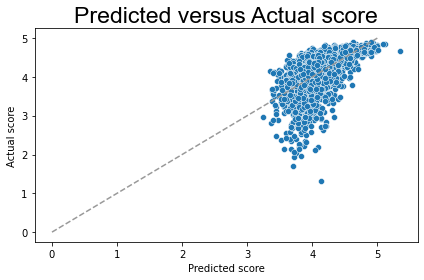

In [178]:
fig, ax = plt.subplots()
sns.scatterplot(y_predv23, y_val)
plt.xlabel('Predicted score')
plt.ylabel('Actual score')
ax.plot(np.linspace(0,5,5), np.linspace(0,5,5), ls="--", c="0.6")
plt.tight_layout()
plt.title('Predicted versus Actual score',family='arial',fontsize=23);
plt.tight_layout()
plt.show;

In [179]:
X_train.columns

Index(['ratings', 'free', 'containsAds', 'editorsChoice', 'top_developer',
       'installs_day', 'updated_days', 'has_video', 'year', 'app_ads',
       'compatibility', 'updates', 'features', 'bugs', 'payments',
       'use_support', 'genre_Adventure', 'genre_Arcade', 'genre_Art & Design',
       'genre_Auto & Vehicles', 'genre_Beauty', 'genre_Board',
       'genre_Books & Reference', 'genre_Business', 'genre_Card',
       'genre_Casino', 'genre_Casual', 'genre_Comics', 'genre_Communication',
       'genre_Dating', 'genre_Education', 'genre_Entertainment',
       'genre_Finance', 'genre_Food & Drink', 'genre_Health & Fitness',
       'genre_House & Home', 'genre_Libraries & Demo', 'genre_Lifestyle',
       'genre_Maps & Navigation', 'genre_Medical', 'genre_Music & Audio',
       'genre_News & Magazines', 'genre_Parenting', 'genre_Personalization',
       'genre_Photography', 'genre_Productivity', 'genre_Puzzle',
       'genre_Racing', 'genre_Role Playing', 'genre_Shopping',
       'ge

## No ads interactions

In [180]:
X_train['no_ads'] = np.where(X_train['containsAds']==0,1,0)
X_val['no_ads'] = np.where(X_val['containsAds']==0,1,0)

X_train['noads_free'] = X_train['no_ads'] * X_train['free']
X_val['noads_free'] = X_val['no_ads'] * X_val['free']

X_train['noads_arcade'] = X_train['no_ads'] * X_train['genre_Arcade']
X_val['noads_arcade'] = X_val['no_ads'] * X_val['genre_Arcade']

X_train['noads_adventure'] = X_train['containsAds'] * X_train['genre_Adventure']
X_val['noads_adventure'] = X_val['containsAds'] * X_val['genre_Adventure']

<ipython-input-180-b180789198d4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['no_ads'] = np.where(X_train['containsAds']==0,1,0)
<ipython-input-180-b180789198d4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val['no_ads'] = np.where(X_val['containsAds']==0,1,0)
<ipython-input-180-b180789198d4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

In [181]:
features24 = ['ratings_cubed','features','app_ads','payments','compatibility',
             'updated_sqrt','top_developer','free','genre_News & Magazines','genre_Art & Design',
             'genre_Libraries & Demo','genre_Dating','genre_Video Players & Editors',
             'genre_Photography','genre_Role Playing','genre_Entertainment',
             'genre_Arcade','free_simulation','ads_adventure','ads_beauty','noads_free']

In [182]:
lr24 = LinearRegression()

lr24.fit(X_train[features24], y_train)

y_pred24 = lr24.predict(X_train[features24])
print('R^2 of linear regression on train set: {:.2f}'.format(lr24.score(X_train[features24], y_train)))
print('MSE of linear regression on train set: {:.2f}'.format((mean_squared_error(y_train, y_pred24))))
print('MAE of linear regression on train set: {:.2f}'.format((mean_absolute_error(y_train, y_pred24))))

R^2 of linear regression on train set: 0.33
MSE of linear regression on train set: 0.14
MAE of linear regression on train set: 0.27


In [183]:
y_predv24 = lr24.predict(X_val[features24])
print('R^2 of linear regression on val set: {:.2f}'.format(lr24.score(X_val[features24], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_val, y_predv24))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_predv24))))

R^2 of linear regression on val set: 0.33
MSE of linear regression on val set: 0.13
MAE of linear regression on val set: 0.26


In [184]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features24].columns, lr24.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

ratings_cubed : 0.01
features : 0.94
app_ads : 0.18
payments : 0.04
compatibility : 0.02
updated_sqrt : -0.03
top_developer : 0.46
free : 0.16
genre_News & Magazines : -0.08
genre_Art & Design : -0.04
genre_Libraries & Demo : -0.04
genre_Dating : -0.22
genre_Video Players & Editors : -0.14
genre_Photography : -0.08
genre_Role Playing : -0.15
genre_Entertainment : -0.11
genre_Arcade : -0.04
free_simulation : -0.17
ads_adventure : -0.14
ads_beauty : -0.19
noads_free : -0.12


In [185]:
check24 = X_val.copy()
check24['score'] = y_val
check24['pred'] = lr24.predict(X_val[features24])
check24['resid'] = check24['pred'] - check24['score']

/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


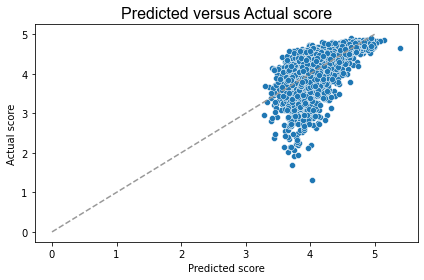

In [186]:
fig, ax = plt.subplots()
sns.scatterplot(y_predv24, y_val)
plt.xlabel('Predicted score')
plt.ylabel('Actual score')
ax.plot(np.linspace(0,5,5), np.linspace(0,5,5), ls="--", c="0.6")
plt.tight_layout()
plt.title('Predicted versus Actual score',family='arial',fontsize=16);
plt.tight_layout()
plt.show;

## House & Home

In [187]:
features25 = ['ratings_cubed','features','app_ads','payments','compatibility',
             'updated_sqrt','top_developer','free','genre_News & Magazines','genre_Art & Design',
             'genre_Libraries & Demo','genre_Dating','genre_Video Players & Editors',
             'genre_Photography','genre_Role Playing','genre_Entertainment',
             'genre_Arcade','free_simulation','ads_adventure','ads_beauty','noads_arcade',
             'noads_free','genre_House & Home']

In [188]:
lr25 = LinearRegression()

lr25.fit(X_train[features25], y_train)

y_pred25 = lr25.predict(X_train[features25])
print('R^2 of linear regression on train set: {:.2f}'.format(lr25.score(X_train[features25], y_train)))
print('MSE of linear regression on train set: {:.2f}'.format((mean_squared_error(y_train, y_pred25))))
print('MAE of linear regression on train set: {:.2f}'.format((mean_absolute_error(y_train, y_pred25))))

R^2 of linear regression on train set: 0.33
MSE of linear regression on train set: 0.14
MAE of linear regression on train set: 0.27


In [189]:
y_predv25 = lr25.predict(X_val[features25])
print('R^2 of linear regression on val set: {:.2f}'.format(lr25.score(X_val[features25], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_val, y_predv25))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_predv25))))

R^2 of linear regression on val set: 0.33
MSE of linear regression on val set: 0.13
MAE of linear regression on val set: 0.26


In [190]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features25].columns, lr25.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

ratings_cubed : 0.01
features : 0.94
app_ads : 0.18
payments : 0.04
compatibility : 0.02
updated_sqrt : -0.03
top_developer : 0.46
free : 0.16
genre_News & Magazines : -0.08
genre_Art & Design : -0.04
genre_Libraries & Demo : -0.04
genre_Dating : -0.22
genre_Video Players & Editors : -0.14
genre_Photography : -0.08
genre_Role Playing : -0.15
genre_Entertainment : -0.11
genre_Arcade : -0.03
free_simulation : -0.17
ads_adventure : -0.14
ads_beauty : -0.19
noads_arcade : -0.09
noads_free : -0.11
genre_House & Home : -0.07


In [191]:
check25 = X_val.copy()
check25['score'] = y_val
check25['pred'] = lr25.predict(X_val[features25])
check25['resid'] = check25['pred'] - check25['score']

/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


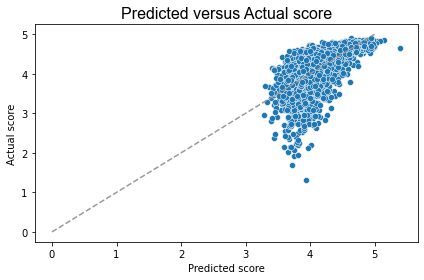

In [192]:
fig, ax = plt.subplots()
sns.scatterplot(y_predv25, y_val)
plt.xlabel('Predicted score')
plt.ylabel('Actual score')
ax.plot(np.linspace(0,5,5), np.linspace(0,5,5), ls="--", c="0.6")
plt.tight_layout()
plt.title('Predicted versus Actual score',family='arial',fontsize=16);
plt.tight_layout()
plt.show;

## Weather and Beauty

In [266]:
features26 = ['ratings_cubed','features','app_ads','payments',
             'top_developer','free','genre_News & Magazines','genre_Art & Design',
             'genre_Libraries & Demo','genre_Dating','genre_Video Players & Editors',
             'genre_Photography','genre_Role Playing','genre_Entertainment',
             'genre_Arcade','genre_House & Home','genre_Personalization', 'genre_Adventure',
             'ads_beauty','noads_free','genre_Weather','genre_Simulation']

In [267]:
lr26 = LinearRegression()

lr26.fit(X_train[features26], y_train)

y_pred26 = lr26.predict(X_train[features26])
print('R^2 of linear regression on train set: {:.2f}'.format(lr26.score(X_train[features26], y_train)))
print('MSE of linear regression on train set: {:.2f}'.format((mean_squared_error(y_train, y_pred26))))
print('MAE of linear regression on train set: {:.2f}'.format((mean_absolute_error(y_train, y_pred26))))

R^2 of linear regression on train set: 0.32
MSE of linear regression on train set: 0.14
MAE of linear regression on train set: 0.27


In [268]:
y_predv26 = lr26.predict(X_val[features26])
print('R^2 of linear regression on val set: {:.2f}'.format(lr26.score(X_val[features26], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_val, y_predv26))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_predv26))))

R^2 of linear regression on val set: 0.31
MSE of linear regression on val set: 0.13
MAE of linear regression on val set: 0.26


In [269]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features26].columns, lr26.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

ratings_cubed : 0.01
features : 0.97
app_ads : 0.18
payments : 0.04
top_developer : 0.47
free : 0.14
genre_News & Magazines : -0.06
genre_Art & Design : -0.04
genre_Libraries & Demo : -0.05
genre_Dating : -0.19
genre_Video Players & Editors : -0.13
genre_Photography : -0.08
genre_Role Playing : -0.13
genre_Entertainment : -0.11
genre_Arcade : -0.05
genre_House & Home : -0.05
genre_Personalization : 0.06
genre_Adventure : -0.13
ads_beauty : -0.19
noads_free : -0.10
genre_Weather : 0.06
genre_Simulation : -0.17


In [270]:
check26 = X_val.copy()
check26['score'] = y_val
check26['pred'] = lr26.predict(X_val[features26])
check26['resid'] = check26['pred'] - check26['score']

/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


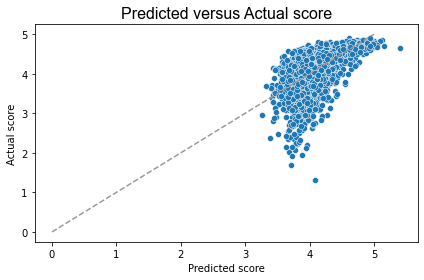

In [271]:
fig, ax = plt.subplots()
sns.scatterplot(y_predv26, y_val)
plt.xlabel('Predicted score')
plt.ylabel('Actual score')
ax.plot(np.linspace(0,5,5), np.linspace(0,5,5), ls="--", c="0.6")
plt.tight_layout()
plt.title('Predicted versus Actual score',family='arial',fontsize=16);
plt.tight_layout()
plt.show;

### Test

In [272]:
X_test_cont = X_test[['ratings','free','containsAds','editorsChoice','top_developer',
        'installs_day','updated_days','has_video','year', 'app_ads',
       'compatibility', 'updates', 'features', 'bugs', 'payments',
       'use_support']]

In [273]:
X_test_cont['ratings_cubed'] = np.cbrt(X_test_cont['ratings'])
X_test_cont['updated_sqrt'] = np.sqrt(X_test_cont['updated_days'])

<ipython-input-273-7523b898649f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_cont['ratings_cubed'] = np.cbrt(X_test_cont['ratings'])


In [274]:
ohe = OneHotEncoder(drop='first', sparse=False)

ohe.fit(X_test[['genre','contentRating']])

ohe_x_test = ohe.transform(X_test[['genre','contentRating']])

columns = ohe.get_feature_names(['genre','contentRating'])

ohe_x_test_df = pd.DataFrame(ohe_x_test, columns=columns, index=X_test.index)

In [275]:
#Merge cont and cat DFs
combo_test_df = pd.concat([X_test_cont, ohe_x_test_df], axis=1)

In [276]:
combo_test_df['free_simulation'] = combo_test_df['free'] * combo_test_df['genre_Simulation']
combo_test_df['ads_adventure'] = combo_test_df['containsAds'] * combo_test_df['genre_Adventure']
combo_test_df['ads_beauty'] = combo_test_df['containsAds'] * combo_test_df['genre_Beauty']

combo_test_df['no_ads'] = np.where(combo_test_df['containsAds']==0,1,0)
combo_test_df['noads_free'] = combo_test_df['no_ads'] * combo_test_df['free']
combo_test_df['noads_arcade'] = combo_test_df['no_ads'] * combo_test_df['genre_Arcade']
combo_test_df['noads_adventure'] = combo_test_df['containsAds'] * combo_test_df['genre_Adventure']

In [277]:
y_pred_test = lr26.predict(combo_test_df[features26])
print('R^2 of linear regression on val set: {:.2f}'.format(lr26.score(combo_test_df[features26], y_test)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_test, y_pred_test))))
print('RMSE of linear regression on val set: {:.2f}'.format(np.sqrt(mean_squared_error(y_test, y_pred_test))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_test, y_pred_test))))

R^2 of linear regression on val set: 0.31
MSE of linear regression on val set: 0.14
RMSE of linear regression on val set: 0.37
MAE of linear regression on val set: 0.28


/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


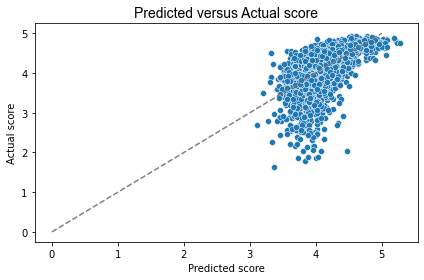

In [278]:
fig, ax = plt.subplots()
sns.scatterplot(y_pred_test, y_test)
plt.xlabel('Predicted score')
plt.ylabel('Actual score')
ax.plot(np.linspace(0,5,5), np.linspace(0,5,5), ls="--", c="0.5")
plt.tight_layout()
plt.title('Predicted versus Actual score',family='arial',fontsize=14);
plt.tight_layout()
plt.savefig('predictedactual_apps.svg');
plt.show;

In [212]:
check27 = X_val.copy()
check27['score'] = y_val
check27['pred'] = lr26.predict(X_val[features26])
check27['resid'] = check27['pred'] - check27['score']

In [213]:
high_resid27 = check27.sort_values('resid',ascending =False).head(600)

In [214]:
check27.sort_values('resid',ascending =False)

,ratings,free,containsAds,editorsChoice,top_developer,installs_day,updated_days,has_video,year,app_ads,compatibility,updates,features,bugs,payments,use_support,genre_Adventure,genre_Arcade,genre_Art & Design,genre_Auto & Vehicles,genre_Beauty,genre_Board,genre_Books & Reference,genre_Business,genre_Card,genre_Casino,genre_Casual,genre_Comics,genre_Communication,genre_Dating,genre_Education,genre_Entertainment,genre_Finance,genre_Food & Drink,genre_Health & Fitness,genre_House & Home,genre_Libraries & Demo,genre_Lifestyle,genre_Maps & Navigation,genre_Medical,genre_Music & Audio,genre_News & Magazines,genre_Parenting,genre_Personalization,genre_Photography,genre_Productivity,genre_Puzzle,genre_Racing,genre_Role Playing,genre_Shopping,genre_Simulation,genre_Social,genre_Sports,genre_Strategy,genre_Tools,genre_Travel & Local,genre_Trivia,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,ratings_cubed,updated_sqrt,free_simulation,ads_adventure,ads_beauty,no_ads,noads_free,noads_arcade,noads_adventure,score,pred,resid
7390,57642.0,1,0,0,0,357.781753,1190,1,2013,0.265720,-0.032281,0.293238,0.136754,0.079100,-0.148733,0.485250,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.628960,5.873362,0.0,0.0,0.0,1,1,1.0,0.0,1.324779,4.088775,2.763996
3260,6117.0,1,1,0,0,1430.615165,194,0,2019,-0.208300,0.000000,0.000000,-0.018720,0.000000,-0.149200,0.079050,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.288559,3.732076,0.0,0.0,0.0,0,0,0.0,0.0,1.696825,3.718848,2.022023
17098,3380.0,1,1,0,0,717.360115,1234,0,2017,0.148570,0.064636,0.129360,0.210863,0.273560,0.517600,0.474125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,15.007404,5.926916,0.0,0.0,0.0,0,0,0.0,0.0,1.958580,3.877087,1.918507
16337,11749.0,1,0,0,0,411.353353,64,0,2014,0.492700,0.156457,0.043175,0.123344,0.188986,0.000000,0.568860,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.733535,2.828427,0.0,0.0,0.0,1,1,0.0,0.0,2.123090,3.946584,1.823494
8013,17878.0,1,1,0,0,259.538022,21,0,2010,-0.139850,0.159100,0.000000,-0.083657,0.212650,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,26.148070,2.140695,0.0,0.0,0.0,0,0,0.0,0.0,1.929050,3.729296,1.800246
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,18587.0,1,1,0,0,596.658711,16,1,2016,-0.148000,0.322400,0.000000,-0.095850,0.008275,0.795100,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,26.489256,2.000000,0.0,0.0,0.0,0,0,0.0,0.0,4.610814,3.810114,-0.800700
11889,9290.0,1,1,0,0,508.646999,676,0,2015,0.201850,0.061106,0.125000,-0.161477,0.304500,0.000000,0.603633,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.021897,5.099020,0.0,0.0,0.0,0,0,0.0,0.0,4.573735,3.760916,-0.812819
18843,6204.0,1,1,0,0,311.720698,5

In [220]:
low_resid27 = check27[(check27['resid'] >= -0.005) & (check27['resid'] <= 0.005)]

In [221]:
low_resid27.sort_values('resid')

,ratings,free,containsAds,editorsChoice,top_developer,installs_day,updated_days,has_video,year,app_ads,compatibility,updates,features,bugs,payments,use_support,genre_Adventure,genre_Arcade,genre_Art & Design,genre_Auto & Vehicles,genre_Beauty,genre_Board,genre_Books & Reference,genre_Business,genre_Card,genre_Casino,genre_Casual,genre_Comics,genre_Communication,genre_Dating,genre_Education,genre_Entertainment,genre_Finance,genre_Food & Drink,genre_Health & Fitness,genre_House & Home,genre_Libraries & Demo,genre_Lifestyle,genre_Maps & Navigation,genre_Medical,genre_Music & Audio,genre_News & Magazines,genre_Parenting,genre_Personalization,genre_Photography,genre_Productivity,genre_Puzzle,genre_Racing,genre_Role Playing,genre_Shopping,genre_Simulation,genre_Social,genre_Sports,genre_Strategy,genre_Tools,genre_Travel & Local,genre_Trivia,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,ratings_cubed,updated_sqrt,free_simulation,ads_adventure,ads_beauty,no_ads,noads_free,noads_arcade,noads_adventure,score,pred,resid
2031,5314.0,1,0,0,0,302.571861,41,1,2012,0.136825,0.033937,0.528700,0.122848,-0.121629,0.000000,0.438925,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.450472,2.530440,0.0,0.0,0.0,1,1,0.0,0.0,3.813910,3.809453,-0.004457
4730,7020.0,1,1,0,0,451.263538,166,1,2015,-0.006900,-0.109600,0.000000,0.094058,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.147513,3.589443,0.0,0.0,0.0,0,0,0.0,0.0,3.777778,3.773348,-0.004430
3349,2247.0,1,1,0,0,1254.705144,66,1,2018,0.140700,-0.256467,0.612400,0.250891,0.000000,0.000000,-0.271150,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.097881,2.850270,0.0,0.0,0.0,0,0,0.0,0.0,3.901709,3.897422,-0.004288
1844,6240.0,1,1,0,0,2272.727273,16,1,2019,0.289207,0.228000,0.518842,0.416852,0.357490,0.441189,0.360900,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.410328,2.000000,0.0,0.0,0.0,0,0,0.0,0.0,4.256778,4.253326,-0.003452
20013,6272.0,1,1,0,0,307.692308,766,0,2012,0.160302,0.232875,0.217850,0.287321,0.284756,-0.375550,0.135100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.441745,5.260865,0.0,0.0,0.0,0,0,0.0,0.0,4.074960,4.071571,-0.003389
4289,36832.0,1,1,0,0,875.656743,92,0,2018,0.154960,0.078980,0.696200,0.090290,0.000000,0.000000,0.048133,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.271708,3.097041,0.0,0.0,0.0,0,0,0.0,0.0,4.108021,4.104680,-0.003342
7467,16705.0,1,1,0,0,600.600601,244,0,2016,0.123245,0.284600,0.000000,0.057265,-0.127120,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.563216,3.952278,0.0,0.0,0.0,0,0,0.0,0.0,3.962197,3.958897,-0.003300
717,50610.0,1,1,0,0,441.111601,140,0,2014,0.031637,0.326567,-0.333475,0.326828,0.083818,0.304800,0.777467,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.989527,3.439791,0.0,0.0,0.0,0,0,0.0,0.0,4.

In [209]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features26].columns, lr26.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

ratings_cubed : 0.01
features : 0.97
app_ads : 0.18
payments : 0.04
top_developer : 0.47
free : 0.17
genre_News & Magazines : -0.06
genre_Art & Design : -0.04
genre_Libraries & Demo : -0.05
genre_Dating : -0.19
genre_Video Players & Editors : -0.13
genre_Photography : -0.08
genre_Role Playing : -0.13
genre_Entertainment : -0.11
genre_Arcade : -0.05
genre_House & Home : -0.05
genre_Personalization : 0.06
free_simulation : -0.17
ads_adventure : -0.14
ads_beauty : -0.19
noads_free : -0.10
genre_Weather : 0.06


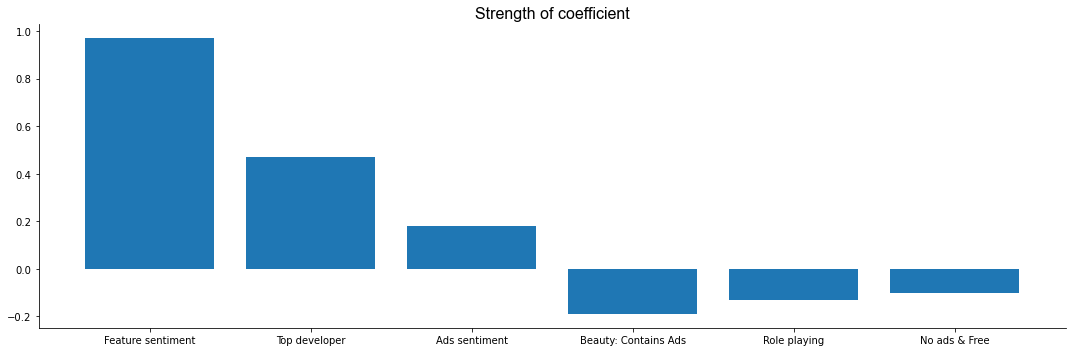

In [222]:
x_values = [0.97,0.47,0.18,-0.19,-0.13,-0.10]
x_labels = ['Feature sentiment','Top developer','Ads sentiment','Beauty: Contains Ads','Role playing','No ads & Free']

plt.figure(figsize=[15,5])
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.bar(x_labels,x_values)   
plt.title('Strength of coefficient',family='arial',fontsize=16)
plt.tight_layout()
plt.savefig('coefficients_apps.svg');
plt.show;

In [206]:
df1 = X_train[features26].copy()

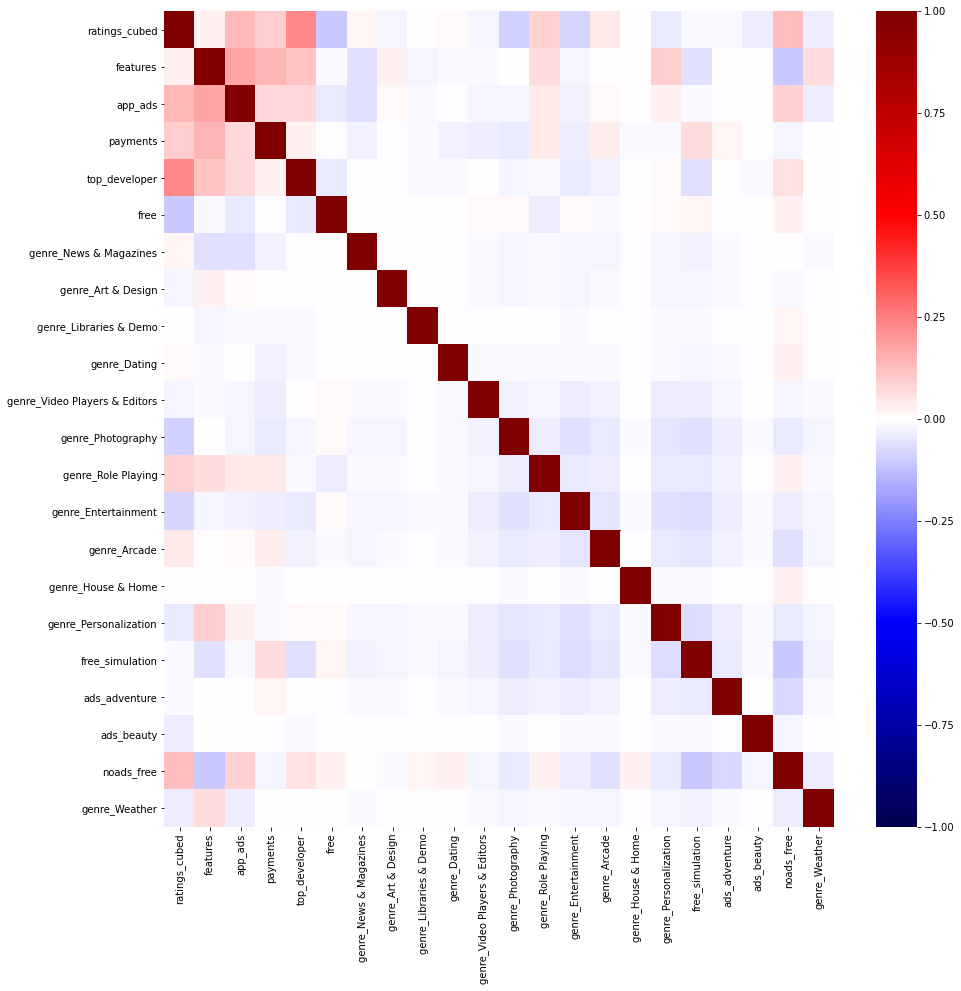

In [207]:
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(df1.corr(), cmap="seismic", vmin=-1, vmax=1, ax=ax);

Great! Model is no longer overfitting